In [1]:
import joblib
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import warnings

from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from tqdm import tqdm

In [2]:
np.random.seed(42)
warnings.filterwarnings('ignore')

# Carregando os datasets

Abaixo observa-se que ambos os datasets `ind_df` e `conn_df` possuem missing values. Em particular, chama a atenção o fato de que em `conn_df` os missing values concentram-se na variável target, a probabilidade de contaminação.

## `conn_df`

In [3]:
conn_df = pd.read_csv('../data/raw/conexoes_espec.csv', sep=';')

In [4]:
conn_df

,V1,V2,grau,proximidade,prob_V1_V2
0,1,2,trabalho,visita_frequente,0.589462
1,1,3,trabalho,visita_rara,0.708465
2,2,4,trabalho,visita_casual,NaN
3,2,5,trabalho,visita_rara,0.638842
4,3,6,amigos,mora_junto,NaN
...,...,...,...,...,...
999994,499998,999996,trabalho,visita_rara,NaN
999995,499998,999997,trabalho,visita_rara,NaN
999996,499999,999998,familia,visita_casual,0.451662
999997,499999,999999,familia,visita_rara,0.186973


In [5]:
conn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999999 entries, 0 to 999998
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   V1           999999 non-null  int64  
 1   V2           999999 non-null  int64  
 2   grau         999999 non-null  object 
 3   proximidade  999999 non-null  object 
 4   prob_V1_V2   499999 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 38.1+ MB


In [6]:
conn_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
V1,999999.0,NaN,NaN,NaN,250000.25,144337.495129,1.0,125000.5,250000.0,375000.0,500000.0
V2,999999.0,NaN,NaN,NaN,500001.0,288674.990255,2.0,250001.5,500001.0,750000.5,1000000.0
grau,999999,3,trabalho,333548,NaN,NaN,NaN,NaN,NaN,NaN,NaN
proximidade,999999,4,visita_rara,400238,NaN,NaN,NaN,NaN,NaN,NaN,NaN
prob_V1_V2,499999.0,NaN,NaN,NaN,0.485162,0.173963,0.074462,0.351677,0.486413,0.61821,0.942245


In [7]:
conn_df['grau'].unique()

array(['trabalho', 'amigos', 'familia'], dtype=object)

In [8]:
conn_df['proximidade'].unique()

array(['visita_frequente', 'visita_rara', 'visita_casual', 'mora_junto'],
      dtype=object)

## `ind_df`

In [9]:
ind_df = pd.read_csv('../data/raw/individuos_espec.csv', sep=';')

In [10]:
ind_df

,name,idade,estado_civil,qt_filhos,estuda,trabalha,pratica_esportes,transporte_mais_utilizado,IMC
0,1,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956
1,2,24.0,casado,0.0,0.0,0.0,1.0,publico,25.378720
2,3,35.0,solteiro,1.0,0.0,0.0,1.0,particular,19.952393
3,4,50.0,casado,1.0,1.0,1.0,0.0,publico,26.732053
4,5,30.0,solteiro,2.0,1.0,0.0,1.0,publico,15.295668
...,...,...,...,...,...,...,...,...,...
999995,999996,34.0,casado,1.0,0.0,1.0,1.0,publico,17.556771
999996,999997,40.0,casado,1.0,0.0,1.0,1.0,particular,24.848402
999997,999998,30.0,divorciado,1.0,0.0,0.0,1.0,publico,NaN
999998,999999,33.0,casado,0.0,1.0,1.0,1.0,publico,16.979569


In [11]:
ind_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   name                       1000000 non-null  int64  
 1   idade                      904063 non-null   float64
 2   estado_civil               949927 non-null   object 
 3   qt_filhos                  971133 non-null   float64
 4   estuda                     959870 non-null   float64
 5   trabalha                   993647 non-null   float64
 6   pratica_esportes           850876 non-null   float64
 7   transporte_mais_utilizado  956967 non-null   object 
 8   IMC                        886130 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 68.7+ MB


In [12]:
ind_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
name,1000000.0,NaN,NaN,NaN,500000.5,288675.278933,1.0,250000.75,500000.5,750000.25,1000000.0
idade,904063.0,NaN,NaN,NaN,30.008431,10.951566,0.0,22.0,29.0,37.0,124.0
estado_civil,949927,4,solteiro,420637,NaN,NaN,NaN,NaN,NaN,NaN,NaN
qt_filhos,971133.0,NaN,NaN,NaN,0.928406,0.997289,0.0,0.0,1.0,1.0,9.0
estuda,959870.0,NaN,NaN,NaN,0.442588,0.496693,0.0,0.0,0.0,1.0,1.0
trabalha,993647.0,NaN,NaN,NaN,0.556739,0.496771,0.0,0.0,1.0,1.0,1.0
pratica_esportes,850876.0,NaN,NaN,NaN,0.599823,0.489934,0.0,0.0,1.0,1.0,1.0
transporte_mais_utilizado,956967,3,publico,574779,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IMC,886130.0,NaN,NaN,NaN,22.472079,7.073692,4.852828,17.420851,21.4312,26.378197,89.158204


In [13]:
ind_df['estado_civil'].unique()

array(['divorciado', 'casado', 'solteiro', nan, 'viuvo'], dtype=object)

In [14]:
ind_df['transporte_mais_utilizado'].unique()

array(['publico', 'particular', 'taxi', nan], dtype=object)

## Combinando `ind_df` e `conn_df`

In [15]:
df_raw = pd.merge(ind_df.rename(columns=lambda x: x + '_V2'),
                  conn_df, 
                  how='right',
                  left_on='name_V2', 
                  right_on='V2')
df_raw = pd.merge(ind_df.rename(columns=lambda x: x + '_V1'),
                  df_raw, 
                  how='right',
                  left_on='name_V1', 
                  right_on='V1')
df_raw = df_raw.drop(['V1', 'V2'], axis=1)
df_raw

,name_V1,idade_V1,estado_civil_V1,qt_filhos_V1,estuda_V1,trabalha_V1,pratica_esportes_V1,transporte_mais_utilizado_V1,IMC_V1,name_V2,...,estado_civil_V2,qt_filhos_V2,estuda_V2,trabalha_V2,pratica_esportes_V2,transporte_mais_utilizado_V2,IMC_V2,grau,proximidade,prob_V1_V2
0,1,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956,2,...,casado,0.0,0.0,0.0,1.0,publico,25.378720,trabalho,visita_frequente,0.589462
1,1,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956,3,...,solteiro,1.0,0.0,0.0,1.0,particular,19.952393,trabalho,visita_rara,0.708465
2,2,24.0,casado,0.0,0.0,0.0,1.0,publico,25.378720,4,...,casado,1.0,1.0,1.0,0.0,publico,26.732053,trabalho,visita_casual,NaN
3,2,24.0,casado,0.0,0.0,0.0,1.0,publico,25.378720,5,...,solteiro,2.0,1.0,0.0,1.0,publico,15.295668,trabalho,visita_rara,0.638842
4,3,35.0,solteiro,1.0,0.0,0.0,1.0,particular,19.952393,6,...,NaN,1.0,0.0,1.0,0.0,publico,20.412942,amigos,mora_junto,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999994,499998,23.0,casado,0.0,1.0,1.0,0.0,publico,22.036885,999996,...,casado,1.0,0.0,1.0,1.0,publico,17.556771,trabalho,visita_rara,NaN
999995,499998,23.0,casado,0.0,1.0,1.0,0.0,publico,22.036885,999997,...,casado,1.0,0.0,1.0,1.0,particular,24.848402,trabalho,visita_rara,NaN
999996,499999,26.0,casado,3.0,0.0,0.0,0.0,taxi,19.543889,999998,...,divorciado,1.0,0.0,0.0,1.0,publico,NaN,familia,visita_casual,0.451662
999997,499999,26.0,casado,3.0,0.0,0.0,0.0,taxi,19.543889,999999,...,casado,0.0,1.0,1.0,1.0,publico,16.979569,familia,visita_rara,0.186973


# Utils

Modelos de classificação do scikit-learn não aceitam probabilidade como variável target, portanto a estratégia adotada para treinar modelos e estimar as probabilidades de contaminação foi:
1. aplicar a transformação logit (inversa da função sigmoide) às probabilidades, a fim de que possam assumir qualquer valor real;
2. treinar modelos de regressão utilizando os logits das probabilidades;
3. aplicar a transformação sigmoide aos resultados obtidos, e assim recuperar o target em termos de probabilidades; e
4. comparar a performance dos modelos usando a função de perda cross-entropy.

In [16]:
def logit(p):
    return np.log(p / (1-p))

def sigmoid(y):
    ey = np.exp(y)
    return ey / (1+ey)

def cross_entropy_loss(y_true, y_pred):
    p, q = sigmoid(y_true), sigmoid(y_pred)
    return -(p*np.log(q) + (1-p)*np.log(1-q)).mean()

# Modelos

In [17]:
shuffle_split = ShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
df_train_index, df_test_index = next(shuffle_split.split(df_raw))
df_raw_train, df_raw_test = df_raw.loc[df_train_index], df_raw.loc[df_test_index]

names_train = np.append(df_raw_train['name_V1'].unique(), df_raw_train['name_V2'].unique())
names_test = np.append(df_raw_test['name_V1'].unique(), df_raw_test['name_V2'].unique())

ind_df_raw_train = ind_df.loc[ind_df['name'].isin(names_train)]
ind_df_raw_test = ind_df.loc[ind_df['name'].isin(names_test)]
ind_train_index, ind_test_index = ind_df_raw_train.index, ind_df_raw_test.index

conn_df_raw_train, conn_df_raw_test = conn_df.loc[df_train_index], conn_df.loc[df_test_index]

In [18]:
categorical_cols = ['estado_civil_V1', 'estado_civil_V2',
                    'transporte_mais_utilizado_V1', 'transporte_mais_utilizado_V2',
                    'grau', 'proximidade']

boolean_cols = ['estuda_V1', 'trabalha_V1', 'pratica_esportes_V1',
                'estuda_V2', 'trabalha_V2', 'pratica_esportes_V2']

numerical_cols = ['idade_V1', 'qt_filhos_V1', 'IMC_V1',
                  'idade_V2', 'qt_filhos_V2', 'IMC_V2']

cols_to_drop = ['name_V1', 'name_V2', 'prob_V1_V2']

## Modelo Baseline

A fim de se obter rapidamente um modelo baseline cuja performance servirá como benchmark para os demais modelos, os missing values foram imputados da forma mais básica possível, de acordo com as seguintes estratégias:
1. variáveis categóricas $\leftarrow$ moda
2. variáveis booleanas $\leftarrow$ média
3. variáveis numéricas $\leftarrow$ mediana.

Para os demais modelos, foram testadas diferentes estratégias para imputar os missing values em `ind_df`. Já no caso de `conn_df`, foi utilizada sempre a mesma estratégia de imputar os missing values com as predições do modelo KNN Regressor (aplicado a uma versão do dataset original com a dimensionalidade reduzida pelo método PCA, buscando preservar cerca de 90% da variância explicada pelas features originais), treinado em um dataset com dados completos. Por fim, o target foi, em todos os casos, estimado utilizando-se a Regressão Linear a fim de que a comparabilidade das estratégias de imputação fosse preservada.


A única exceção a estas regras foi o último modelo, LightGBM Regressor, por se tratar de um que a presença de missing values entre os dados não representa um problema.

In [19]:
df_bl = df_raw.copy(deep=True)

df_bl['prob_V1_V2'].fillna(df_bl['prob_V1_V2'].median(skipna=True), inplace=True)

In [20]:
X_bl = df_bl.drop(cols_to_drop, axis=1)
y_bl = df_bl['prob_V1_V2']

X_bl_train_, X_bl_test_, y_bl_train, y_bl_test = train_test_split(X_bl,
                                                                  logit(y_bl),
                                                                  test_size=0.4,
                                                                  random_state=42)

In [21]:
X_bl_train, X_bl_test = X_bl_train_.copy(deep=True), X_bl_test_.copy(deep=True)

mode_imp = SimpleImputer(strategy='most_frequent')
mean_imp = SimpleImputer(strategy='mean')
median_imp = SimpleImputer(strategy='median')

X_bl_train[categorical_cols] = mode_imp.fit_transform(X_bl_train_[categorical_cols])
X_bl_train[boolean_cols] = mean_imp.fit_transform(X_bl_train_[boolean_cols])
X_bl_train[numerical_cols] = median_imp.fit_transform(X_bl_train_[numerical_cols])

X_bl_test[categorical_cols] = mode_imp.transform(X_bl_test_[categorical_cols])
X_bl_test[boolean_cols] = mean_imp.transform(X_bl_test_[boolean_cols])
X_bl_test[numerical_cols] = median_imp.transform(X_bl_test_[numerical_cols])

In [22]:
one_enc = OneHotEncoder(drop='first', sparse=False)
one_enc.fit(X_bl_train[categorical_cols])

one_hot_cols = one_enc.get_feature_names(categorical_cols)

X_bl_train[one_hot_cols] = one_enc.transform(X_bl_train[categorical_cols])
X_bl_train.drop(categorical_cols, axis=1, inplace=True)

X_bl_test[one_hot_cols] = one_enc.transform(X_bl_test[categorical_cols])
X_bl_test.drop(categorical_cols, axis=1, inplace=True)

In [23]:
bl_model = LinearRegression().fit(X_bl_train, y_bl_train)

In [24]:
train_loss = cross_entropy_loss(y_bl_train, bl_model.predict(X_bl_train))
test_loss = cross_entropy_loss(y_bl_test, bl_model.predict(X_bl_test))

print('baseline train loss:', train_loss)
print('baseline test loss:', test_loss)

baseline train loss: 0.684272325646911
baseline test loss: 0.6842074405738243


## Modelo 1

A imputação dos missing values em `ind_df` foi feita utilizando o KNNImputer, um método computacionalmente bastante custoso. Em se tratando de um dataset com 1M de linhas, este processo teve uma duração média de 8 horas e 30 minutos. Por outro lado, a imputação do target em `conn_df` foi bem rápida, uma vez que a dimensionalidade do dataset foi reduzida de 33 features para 17 após aplicação do PCA.

In [25]:
# ind_df_1 = ind_df.copy(deep=True)

# cat_to_values = {'divorciado': 0,
#                  'casado': 1,
#                  'solteiro': 2,
#                  'viuvo': 3,
#                  'publico': 4,
#                  'particular': 5,
#                  'taxi': 6}

# ind_df_1_ = ind_df_1.replace(cat_to_values)

# scaler = MinMaxScaler()
# ind_df_1_ = scaler.fit_transform(ind_df_1_.drop('name', axis=1))

In [26]:
# %%time

# knn_imp = KNNImputer(weights='distance')

# ind_df_1_ = knn_imp.fit_transform(ind_df_1_)

In [27]:
# ind_df_1_ = pd.DataFrame(scaler.inverse_transform(ind_df_1_), columns=ind_df_1_.columns)
# ind_df_1 = pd.concat([ind_df_1['name'], ind_df_1_], axis=1)

In [28]:
# cols = ['estado_civil', 'transporte_mais_utilizado']
# values_to_cat = {v: k for (k, v) in cat_to_values.items()}
# ind_df_1[cols] = ind_df_1[cols].round().replace(values_to_cat)

In [29]:
ind_df_1 = pd.read_csv('../data/processed/ind_df_filled_knn.csv')

ind_df_1

,name,idade,estado_civil,qt_filhos,estuda,trabalha,pratica_esportes,transporte_mais_utilizado,IMC
0,1,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956
1,2,24.0,casado,0.0,0.0,0.0,1.0,publico,25.378720
2,3,35.0,solteiro,1.0,0.0,0.0,1.0,particular,19.952393
3,4,50.0,casado,1.0,1.0,1.0,0.0,publico,26.732053
4,5,30.0,solteiro,2.0,1.0,0.0,1.0,publico,15.295668
...,...,...,...,...,...,...,...,...,...
999995,999996,34.0,casado,1.0,0.0,1.0,1.0,publico,17.556771
999996,999997,40.0,casado,1.0,0.0,1.0,1.0,particular,24.848402
999997,999998,30.0,divorciado,1.0,0.0,0.0,1.0,publico,16.856449
999998,999999,33.0,casado,0.0,1.0,1.0,1.0,publico,16.979569


In [30]:
def create_df(ind_df, conn_df):
    df = pd.merge(ind_df.rename(columns=lambda x: x + '_V2'),
                  conn_df,
                  how='right',
                  left_on='name_V2', 
                  right_on='V2')
    df = pd.merge(ind_df.rename(columns=lambda x: x + '_V1'),
                  df,
                  how='right',
                  left_on='name_V1', 
                  right_on='V1')
    df = df.drop(['V1', 'V2'], axis=1)
    return df

In [31]:
df_1 = create_df(ind_df_1, conn_df)
df_1

,name_V1,idade_V1,estado_civil_V1,qt_filhos_V1,estuda_V1,trabalha_V1,pratica_esportes_V1,transporte_mais_utilizado_V1,IMC_V1,name_V2,...,estado_civil_V2,qt_filhos_V2,estuda_V2,trabalha_V2,pratica_esportes_V2,transporte_mais_utilizado_V2,IMC_V2,grau,proximidade,prob_V1_V2
0,1,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956,2,...,casado,0.0,0.0,0.0,1.0,publico,25.378720,trabalho,visita_frequente,0.589462
1,1,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956,3,...,solteiro,1.0,0.0,0.0,1.0,particular,19.952393,trabalho,visita_rara,0.708465
2,2,24.0,casado,0.0,0.0,0.0,1.0,publico,25.378720,4,...,casado,1.0,1.0,1.0,0.0,publico,26.732053,trabalho,visita_casual,NaN
3,2,24.0,casado,0.0,0.0,0.0,1.0,publico,25.378720,5,...,solteiro,2.0,1.0,0.0,1.0,publico,15.295668,trabalho,visita_rara,0.638842
4,3,35.0,solteiro,1.0,0.0,0.0,1.0,particular,19.952393,6,...,casado,1.0,0.0,1.0,0.0,publico,20.412942,amigos,mora_junto,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999994,499998,23.0,casado,0.0,1.0,1.0,0.0,publico,22.036885,999996,...,casado,1.0,0.0,1.0,1.0,publico,17.556771,trabalho,visita_rara,NaN
999995,499998,23.0,casado,0.0,1.0,1.0,0.0,publico,22.036885,999997,...,casado,1.0,0.0,1.0,1.0,particular,24.848402,trabalho,visita_rara,NaN
999996,499999,26.0,casado,3.0,0.0,0.0,0.0,taxi,19.543889,999998,...,divorciado,1.0,0.0,0.0,1.0,publico,16.856449,familia,visita_casual,0.451662
999997,499999,26.0,casado,3.0,0.0,0.0,0.0,taxi,19.543889,999999,...,casado,0.0,1.0,1.0,1.0,publico,16.979569,familia,visita_rara,0.186973


In [32]:
def pca_transform(df, n_components=0.9):
    scaler = MinMaxScaler()
    pca = PCA(n_components, random_state=42)
    
    df_ = pd.get_dummies(df.drop(cols_to_drop, axis=1))
    df_ = pca.fit_transform(scaler.fit_transform(df_))
    
    pca_comps = [f'pc_{n+1}' for n in range(df_.shape[1])]
    df_ = pd.DataFrame(df_, columns=pca_comps)
    df_['prob_V1_V2'] = df['prob_V1_V2']
    
    return df_

In [33]:
df_1_pca = pca_transform(df_1)

In [34]:
def knn_impute_prob(df_pca):
    mask = df_pca['prob_V1_V2'].notna()
    
    scaler = MinMaxScaler()

    X_pca_notna = scaler.fit_transform(df_pca.loc[mask].drop('prob_V1_V2', axis=1))
    y_pca_notna = df_pca.loc[mask, 'prob_V1_V2']

    X_pca_isna = scaler.transform(df_pca.loc[~mask].drop('prob_V1_V2', axis=1))
    
    knn_reg_imp = KNeighborsRegressor(weights='distance', n_jobs=-1)
    knn_reg_imp.fit(X_pca_notna, y_pca_notna)

    df_pca.loc[~mask, 'prob_V1_V2'] = knn_reg_imp.predict(X_pca_isna)
    
    return df_pca

In [35]:
# df_1_pca = knn_impute_prob(df_1_pca)

In [36]:
# df_1_pca['prob_V1_V2'].to_csv('../data/processed/df_1_prob_V1_V2_filled_knn.csv', index=False)

In [37]:
# df_1['prob_V1_V2'] = df_1_pca['prob_V1_V2']

In [38]:
df_1['prob_V1_V2'] = pd.read_csv('../data/processed/df_1_prob_V1_V2_filled_knn.csv')

In [39]:
X_1 = pd.get_dummies(df_1.drop(cols_to_drop, axis=1), drop_first=True)
y_1 = df_1['prob_V1_V2']

In [40]:
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1,
                                                            logit(y_1),
                                                            test_size=0.4,
                                                            random_state=42)

In [41]:
lr_1_model = LinearRegression().fit(X_1_train, y_1_train)

In [42]:
train_loss = cross_entropy_loss(y_1_train, lr_1_model.predict(X_1_train))
test_loss = cross_entropy_loss(y_1_test, lr_1_model.predict(X_1_test))

print('lr_1 train loss:', train_loss)
print('lr_1 test loss:', test_loss)

lr_1 train loss: 0.6581942051716074
lr_1 test loss: 0.6582968403020213


## Modelo 2

Observamos uma melhora significativa na performance do Modelo 1 em relação ao do Baseline, no entanto a um custo de mais de 8 horas de treinamento. Para a imputação dos missing values em `ind_df` no Modelo 2, tentamos então realizá-la utilizando EDA, e tentando encontrar padrões e correspondências entre os dados.

In [43]:
ind_df_2 = ind_df.copy(deep=True)

In [44]:
ind_df_2.isna().mean().sort_values()

name                         0.000000
trabalha                     0.006353
qt_filhos                    0.028867
estuda                       0.040130
transporte_mais_utilizado    0.043033
estado_civil                 0.050073
idade                        0.095937
IMC                          0.113870
pratica_esportes             0.149124
dtype: float64

In [45]:
ind_df_2.corr().round(3)

,name,idade,qt_filhos,estuda,trabalha,pratica_esportes,IMC
name,1.000,-0.001,0.000,-0.001,0.001,-0.000,0.001
idade,-0.001,1.000,0.116,-0.139,0.137,0.001,-0.000
qt_filhos,0.000,0.116,1.000,-0.080,0.079,-0.001,-0.000
estuda,-0.001,-0.139,-0.080,1.000,-0.096,-0.000,0.000
trabalha,0.001,0.137,0.079,-0.096,1.000,0.001,-0.001
pratica_esportes,-0.000,0.001,-0.001,-0.000,0.001,1.000,-0.001
IMC,0.001,-0.000,-0.000,0.000,-0.001,-0.001,1.000


Uma observação interessante acima é a correlação praticamente nula entre as variáveis `pratica_esportes`, `IMC` e as demais.

In [46]:
ind_df_2['qt_filhos'].value_counts(normalize=True)

0.0    0.413333
1.0    0.341031
2.0    0.171049
3.0    0.057057
4.0    0.014179
5.0    0.002797
6.0    0.000490
7.0    0.000055
8.0    0.000009
9.0    0.000001
Name: qt_filhos, dtype: float64

Por conta do baixo volume de observações com `qt_filhos > 1`, adotei como estratégia bucketizar todas essas observações. Assim, o número de categorias em `qt_filhos` caiu para 3, mas cada uma com um volume representativo de observações.

In [47]:
def bucketize_qt_filhos(df):
    df.loc[df['qt_filhos'] > 1, 'qt_filhos'] = 2
    return df

In [48]:
ind_df_2 = bucketize_qt_filhos(ind_df_2)
ind_df_2['qt_filhos'].value_counts(normalize=True)

0.0    0.413333
1.0    0.341031
2.0    0.245637
Name: qt_filhos, dtype: float64

In [49]:
ind_df_2['estuda'].value_counts(normalize=True)

0.0    0.557412
1.0    0.442588
Name: estuda, dtype: float64

In [50]:
ind_df_2['trabalha'].value_counts(normalize=True)

1.0    0.556739
0.0    0.443261
Name: trabalha, dtype: float64

### EDA `ind_df`

#### `idade`

Começamos analisando como `idade` se relaciona com `estado_civil`, `qt_filhos`, `estuda` e `trabalha`. Não seria nenhum absurdo supor que pessoas mais jovens tendem a serem solteiras, a não ter filhos, a estudarem e a não trabalharem. E como vemos abaixo, os dados corroboram essas hipóteses.

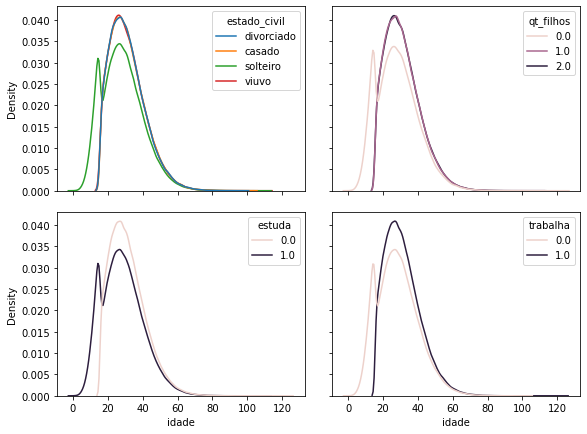

In [51]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey=True)
fig.tight_layout()

sns.kdeplot(x='idade', hue='estado_civil', data=ind_df_2, common_norm=False, ax=ax[0, 0])
sns.kdeplot(x='idade', hue='qt_filhos', data=ind_df_2, common_norm=False, ax=ax[0, 1])
sns.kdeplot(x='idade', hue='estuda', data=ind_df_2, common_norm=False, ax=ax[1, 0])
sns.kdeplot(x='idade', hue='trabalha', data=ind_df_2, common_norm=False, ax=ax[1, 1]);

De fato, vemos nos gráficos acima um padrão peculiar quando a idade é cerca de 16 anos, o que poderia talvez sugerir a existência de duas distribuições distintas dentro dessa população. Por conta disso, criamos uma nova variável chamada `idade_16mais` em que segmentamos as pessoas com menos de, e com mais de, 16 anos.

In [52]:
def impute_idade_16mais(df):
    df['idade_16mais'] = np.nan
    df.loc[df['idade'] >= 16, 'idade_16mais'] = True
    df.loc[df['idade'] < 16, 'idade_16mais'] = False
    return df

In [53]:
ind_df_2 = impute_idade_16mais(ind_df_2)

cols = ['estado_civil', 'qt_filhos', 'estuda', 'trabalha']

for c in cols:
    tmp = (ind_df_2
           .groupby('idade_16mais')[c]
           .value_counts(normalize=True)
           .mul(100)
           .rename('pct')
           .reset_index())
    display(tmp)

,idade_16mais,estado_civil,pct
0,False,solteiro,100.000000
1,True,solteiro,39.995511
2,True,casado,30.026507
3,True,divorciado,19.977881
4,True,viuvo,10.000100


,idade_16mais,qt_filhos,pct
0,False,0.0,100.000000
1,True,0.0,36.794654
2,True,1.0,36.770860
3,True,2.0,26.434487


,idade_16mais,estuda,pct
0,False,1.0,100.00000
1,True,0.0,60.02621
2,True,1.0,39.97379


,idade_16mais,trabalha,pct
0,False,0.0,100.000000
1,True,1.0,59.959506
2,True,0.0,40.040494


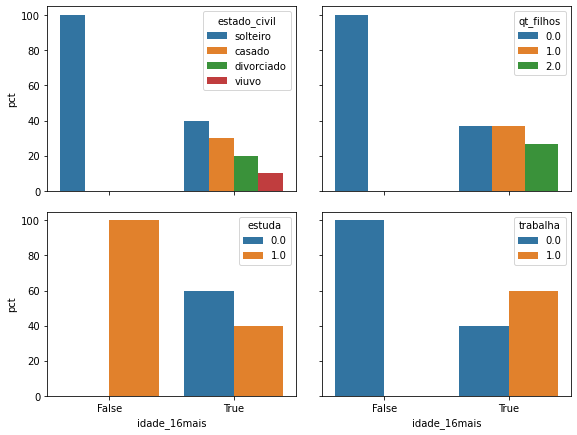

In [54]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey=True)
fig.tight_layout()

cols = ['estado_civil', 'qt_filhos', 'estuda', 'trabalha']

for n, c in enumerate(cols):
    tmp = (ind_df_2
           .groupby('idade_16mais')[c]
           .value_counts(normalize=True)
           .mul(100)
           .rename('pct')
           .reset_index())
    sns.barplot(x='idade_16mais', y='pct', hue=c, data=tmp, ax=ax[n//2, n%2])

ax[0, 0].set_xlabel('')
ax[0, 1].set_xlabel('')
ax[0, 1].set_ylabel('')
ax[1, 1].set_ylabel('');

In [55]:
(ind_df_2
 .loc[ind_df_2['idade_16mais'] == False]
 .corr()
 .dropna(axis=0, how='all')
 .dropna(axis=1, how='all')
 .round(3))

,name,idade,pratica_esportes,IMC
name,1.000,-0.003,0.003,-0.002
idade,-0.003,1.000,0.004,0.003
pratica_esportes,0.003,0.004,1.000,0.003
IMC,-0.002,0.003,0.003,1.000


In [56]:
(ind_df_2
 .loc[ind_df_2['idade_16mais'] == True]
 .corr()
 .dropna(axis=0, how='all')
 .dropna(axis=1, how='all')
 .round(3))

,name,idade,qt_filhos,estuda,trabalha,pratica_esportes,IMC
name,1.000,-0.001,0.000,0.000,-0.000,-0.000,0.001
idade,-0.001,1.000,0.001,-0.001,-0.001,0.000,0.000
qt_filhos,0.000,0.001,1.000,0.000,-0.001,-0.001,-0.000
estuda,0.000,-0.001,0.000,1.000,-0.000,0.000,-0.000
trabalha,-0.000,-0.001,-0.001,-0.000,1.000,0.001,0.000
pratica_esportes,-0.000,0.000,-0.001,0.000,0.001,1.000,-0.002
IMC,0.001,0.000,-0.000,-0.000,0.000,-0.002,1.000


Os dados acima suportam as nossas hipóteses iniciais e nos leva a sugerir a seguinte estratégia para imputar os missing values em `idade`:

1. se `estado_civl = solteiro`, `qt_filhos = 0`, `estuda = 1` e `trabalha = 0`, então `idade` é preenchida com amostras aleatórias dos próprios dados observados e vindos do subgrupo de pessoas com até 16 anos;
2. caso contrário, a restrição da idade é retirada e a imputação de `idade` é feita utilizando-se uma amostragem aleatória de todos os dados observados.

Essa estratégia é implementada abaixo de forma iterativa até que `idade` esteja completa.

In [57]:
ind_df_2['idade'].describe().T

count    904063.000000
mean         30.008431
std          10.951566
min           0.000000
25%          22.000000
50%          29.000000
75%          37.000000
max         124.000000
Name: idade, dtype: float64

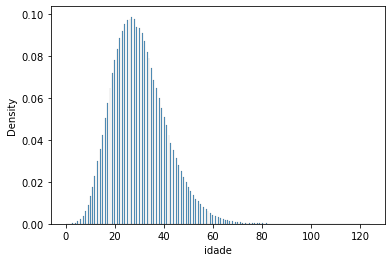

In [58]:
sns.histplot(data=ind_df_2, x='idade', stat='density', bins=320);

In [59]:
def impute_idade(df, impute_below, below_conds, idade_thresh=16, col_name='idade'):
    missing_mask = df[col_name].isna()
    samples = df.loc[~missing_mask, col_name].sample(n=missing_mask.sum())
    
    samples_mask = (samples < idade_thresh) if impute_below else (samples >= idade_thresh)
    below_mask = (df[below_conds.keys()] == below_conds.values()).all(axis=1)
    impute_mask = below_mask if impute_below else ~below_mask
    
    samples_idx = samples[samples_mask].index
    check_samples_idx = impute_mask.rename('valid').to_frame().query('valid == True').index
    valid_samples_idx = samples_idx[samples_idx.isin(check_samples_idx)]
    
    impute_missing_mask = impute_mask & missing_mask
    impute_missing_idx = (impute_missing_mask
                          .rename('impute_missing')
                          .to_frame()
                          .query('impute_missing == True')
                          .index)

    if len(valid_samples_idx) < len(impute_missing_idx):
        impute_missing_idx = (impute_missing_idx
                              .to_series(index=range(len(impute_missing_idx)))
                              .sample(n=len(valid_samples_idx))
                              .values)
    else:
        valid_samples_idx = (valid_samples_idx
                             .to_series(index=range(len(valid_samples_idx)))
                             .sample(n=len(impute_missing_idx))
                             .values)
    
    df.loc[impute_missing_idx, col_name] = samples[valid_samples_idx].values
    
    return df

In [60]:
conds_ate16 = dict(zip(cols, ['solteiro', 0, 1, 0]))
mask = ind_df_2['idade'].isna()

while mask.sum() > 0:
    ind_df_2 = impute_idade(ind_df_2,
                            impute_below=True,
                            below_conds=conds_ate16)
    ind_df_2 = impute_idade(ind_df_2,
                            impute_below=False,
                            below_conds=conds_ate16)
    
    if ind_df_2['idade'].isna().sum() < mask.sum():
        print('>', end='')
    else:
        print('.', end='')
        
    mask = ind_df_2['idade'].isna()

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>.>>>>>.>>>.>>.>.>...>......>>...>.......................................>

In [61]:
ind_df_2 = impute_idade_16mais(ind_df_2)

In [62]:
ind_df_2['idade'].describe().T

count    1000000.000000
mean          29.994734
std           10.963111
min            0.000000
25%           22.000000
50%           29.000000
75%           37.000000
max          124.000000
Name: idade, dtype: float64

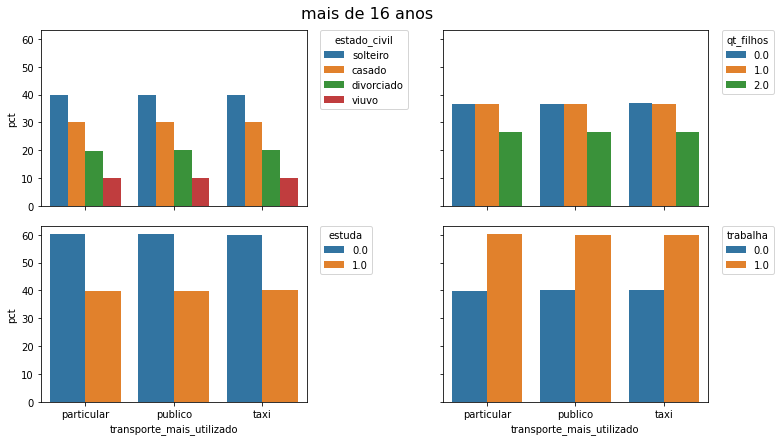

In [63]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)
fig.tight_layout(w_pad=12)
fig.subplots_adjust(top=0.925)
fig.suptitle('mais de 16 anos', fontsize=16)

mask = ind_df_2['idade_16mais']

cols = ['estado_civil', 'qt_filhos', 'estuda', 'trabalha']
for n, c in enumerate(cols):
    tmp = (ind_df_2
           .loc[mask]
           .groupby('transporte_mais_utilizado')[c]
           .value_counts(normalize=True)
           .rename('pct')
           .mul(100)
           .reset_index())
    sns.barplot(x='transporte_mais_utilizado', y='pct', hue=c, data=tmp, ax=ax[n//2, n%2])
    ax[n//2, n%2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, title=c)
    
ax[0, 0].set_xlabel('')
ax[0, 1].set_xlabel('')
ax[0, 1].set_ylabel('')
ax[1, 1].set_ylabel('');

Tendo em vista todos os resultados acima, imputamos os missing values em `estado_civil`, `qt_filhos`, `estuda` e `trabalha` de acordo com as seguintes regras:
1. se `idade < 16`, então `estado_civil, qt_filhos, estuda, trabalha` $\leftarrow$ `solteiro, 0, 1, 0`;
2. caso contrário, preenchemos com o valor esperado das observações em que `idade > 15` para as variáveis numéricas, e para `estado_civil`, imputamos os missing values com uma nova categoria apelidada de `outros`, dado o volume significativo destes;
3. no caso especial da variável `trabalha`, temos ainda uma informação adicional vinda da variável `grau` em `conn_df` que nos permite imputar com certeza missing values de observações em que `grau = trabalho`.

In [64]:
ind_df_2.loc[mask, 'estado_civil'].value_counts(normalize=True)

solteiro      0.399142
casado        0.300866
divorciado    0.199859
viuvo         0.100133
Name: estado_civil, dtype: float64

In [65]:
ind_df_2.loc[~mask & ind_df_2['estado_civil'].isna(), 'estado_civil'] = 'solteiro'
ind_df_2.loc[~mask & ind_df_2['qt_filhos'].isna(), 'qt_filhos'] = 0
ind_df_2.loc[~mask & ind_df_2['estuda'].isna(), 'estuda'] = 1
ind_df_2.loc[~mask & ind_df_2['trabalha'].isna(), 'trabalha'] = 0

names = np.append(conn_df.loc[conn_df['grau'] == 'trabalho', 'V1'].unique(),
                  conn_df.loc[conn_df['grau'] == 'trabalho', 'V2'].unique())
ind_df_2.loc[mask & ind_df_2.index.isin(names), 'trabalha'] = 1

ind_df_2.loc[mask & ind_df_2['estado_civil'].isna(), 'estado_civil'] = 'outros'
for c in ['qt_filhos', 'estuda', 'trabalha']:
    pct_df = ind_df_2.loc[mask, c].value_counts(normalize=True)
    ind_df_2.loc[mask & ind_df_2[c].isna(), c] = sum(pct_df.index*pct_df.values)

#### `transporte_mais_utilizado`

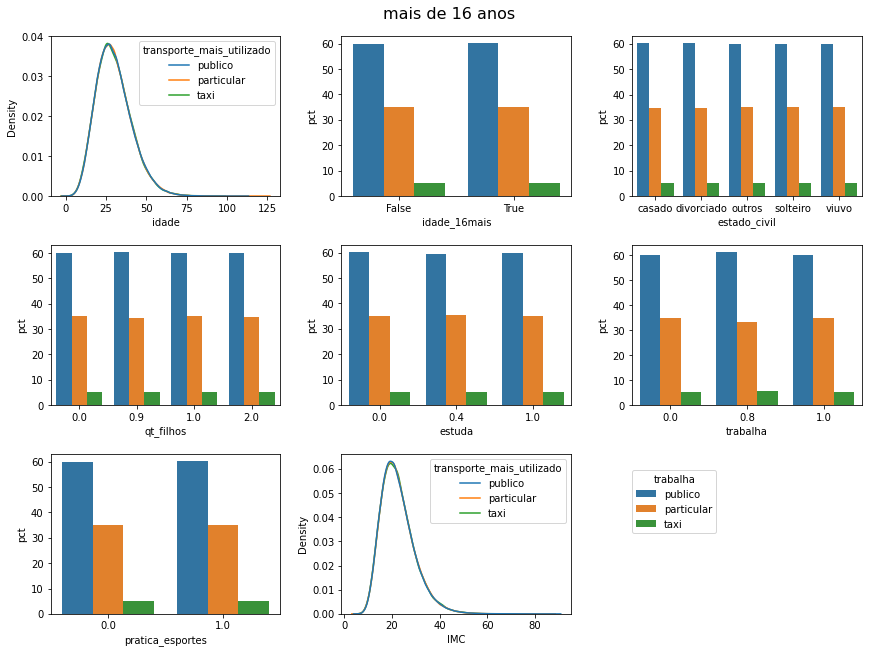

In [66]:
fig, ax = plt.subplots(3, 3, figsize=(12, 9))
fig.tight_layout(w_pad=3, h_pad=3)
fig.subplots_adjust(top=0.935)
fig.suptitle('mais de 16 anos', fontsize=16)

sns.kdeplot(x='idade', hue='transporte_mais_utilizado', data=ind_df_2, common_norm=False, ax=ax[0, 0])

cols = ['idade_16mais', 'estado_civil', 'qt_filhos', 'estuda', 'trabalha', 'pratica_esportes']
for n, c in enumerate(cols, start=1):
    tmp = (ind_df_2
           .groupby(c)['transporte_mais_utilizado']
           .value_counts(normalize=True)
           .rename('pct')
           .mul(100)
           .reset_index())
    g = sns.barplot(x=c, y='pct', hue='transporte_mais_utilizado', data=tmp, ax=ax[n//3, n%3])
    if c in ['qt_filhos', 'estuda', 'trabalha']:
        g.set_xticklabels(labels=['{:.1f}'.format(x) for x in sorted(tmp[c].unique())])
    ax[n//3, n%3].get_legend().remove()
    
ax[1, 2].legend(bbox_to_anchor=(0, -0.8), loc=3, borderaxespad=0, title='trabalha')

sns.kdeplot(x='IMC', hue='transporte_mais_utilizado', data=ind_df_2, common_norm=False, ax=ax[2, 1])

fig.delaxes(ax[2, 2]);

Como vemos acima, as demais variáveis não nos dão pistas de uma boa forma de imputar missing values em `transporte_mais_utilizado`. Portanto, dado o volume significativo de missing values nesta variável, equivalente à categoria `taxi`, eu optei por criar uma nova categoria apelidada de `outros` pra preencher estes valores.

In [67]:
ind_df_2['transporte_mais_utilizado'].value_counts(normalize=True)

publico       0.600626
particular    0.349111
taxi          0.050263
Name: transporte_mais_utilizado, dtype: float64

In [68]:
ind_df_2['transporte_mais_utilizado'].fillna('outros', inplace=True)

#### `pratica_esportes`

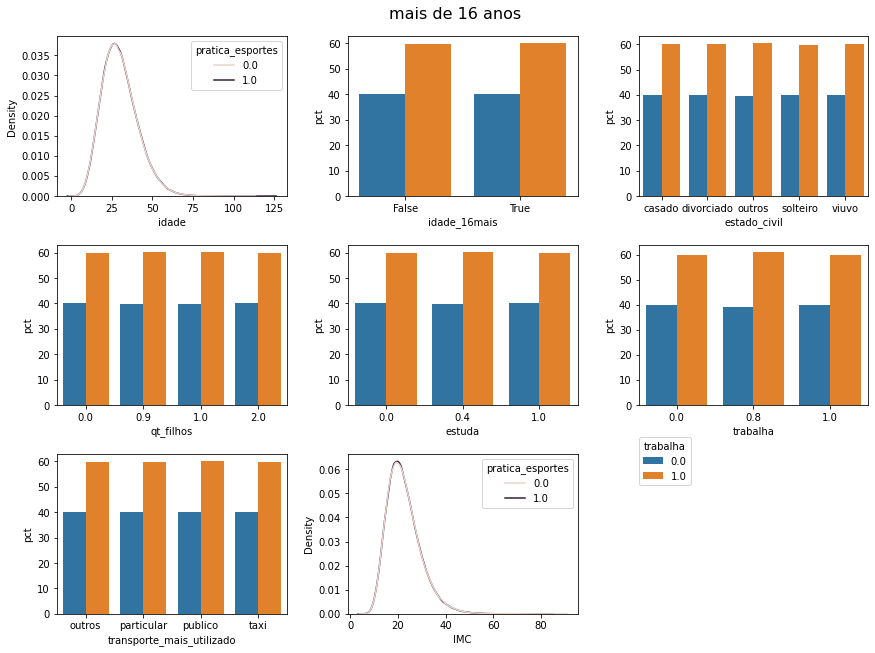

In [69]:
fig, ax = plt.subplots(3, 3, figsize=(12, 9))
fig.tight_layout(w_pad=3, h_pad=3)
fig.subplots_adjust(top=0.935)
fig.suptitle('mais de 16 anos', fontsize=16)

sns.kdeplot(x='idade', hue='pratica_esportes', data=ind_df_2, common_norm=False, ax=ax[0, 0])

cols = ['idade_16mais', 'estado_civil', 'qt_filhos', 'estuda', 'trabalha', 'transporte_mais_utilizado']
for n, c in enumerate(cols, start=1):
    tmp = (ind_df_2
           .groupby(c)['pratica_esportes']
           .value_counts(normalize=True)
           .rename('pct')
           .mul(100)
           .reset_index())
    g = sns.barplot(x=c, y='pct', hue='pratica_esportes', data=tmp, ax=ax[n//3, n%3])
    if c in ['qt_filhos', 'estuda', 'trabalha']:
        g.set_xticklabels(labels=['{:.1f}'.format(x) for x in sorted(tmp[c].unique())])
    ax[n//3, n%3].get_legend().remove()
    
ax[1, 2].legend(bbox_to_anchor=(0, -0.5), loc=3, borderaxespad=0, title='trabalha')

sns.kdeplot(x='IMC', hue='pratica_esportes', data=ind_df_2, common_norm=False, ax=ax[2, 1])

fig.delaxes(ax[2, 2]);

Caso similar ao de `tranporte_mais_utilizado`, e com missing values imputados utilizando-se o valor esperado da variável.

In [70]:
pct_df = ind_df_2['pratica_esportes'].value_counts(normalize=True)
pct_df

1.0    0.599823
0.0    0.400177
Name: pratica_esportes, dtype: float64

In [71]:
ind_df_2['pratica_esportes'].fillna(sum(pct_df.index*pct_df.values), inplace=True)

#### `IMC`

Para esta variável numérica e contínua, a estratégia de imputação utilizada foi a mesma utilizada para `idade`, utilizando-se uma amostragem aleatória dos dados observados.

In [72]:
ind_df_2['IMC'].describe().T

count    886130.000000
mean         22.472079
std           7.073692
min           4.852828
25%          17.420851
50%          21.431200
75%          26.378197
max          89.158204
Name: IMC, dtype: float64

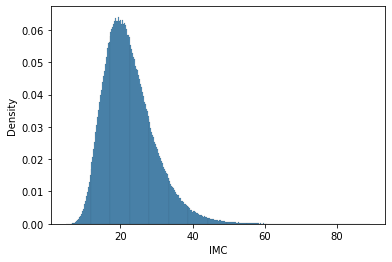

In [73]:
sns.histplot(data=ind_df_2, x='IMC', stat='density', bins=320);

In [74]:
mask_imc_isna = ind_df_2['IMC'].isna()

ind_df_2.loc[mask_imc_isna, 'IMC'] = (ind_df_2
                                      .loc[~mask_imc_isna, 'IMC']
                                      .sample(n=mask_imc_isna.sum(),
                                              replace=True,
                                              random_state=42)
                                      .values)

In [75]:
ind_df_2['IMC'].describe().T

count    1000000.000000
mean          22.471856
std            7.073058
min            4.852828
25%           17.421579
50%           21.433476
75%           26.375954
max           89.158204
Name: IMC, dtype: float64

In [76]:
# def fit_distribution(data, d):
#     try:
#         dist = getattr(stats, d)
#     except:
#         return -1
#     param = dist.fit(data)
#     ks_res = stats.kstest(data, d, args=param)
#     return d, param, ks_res

In [77]:
# dist_continuous = [d for d in dir(stats) if isinstance(getattr(stats, d), stats.rv_continuous)]

In [78]:
# %%time

# res_imc = [fit_distribution(ind_df_2['IMC'].dropna(), d) for d in tqdm(dist_continuous)]

In [79]:
# res_imc.sort(key=lambda x: x[1].statistic, reverse=True)
# for r in res_imc[:10]:
#     print(f'{r[0]}: statistic={r[1].statistic}, pvalue={r[1].pvalue}')

In [80]:
# %%time

# res_idade = [fit_distribution(ind_df_2['idade'].dropna(), d) for d in tqdm(dist_continuous)]

In [81]:
# res_idade.sort(key=lambda x: x[1].statistic, reverse=True)
# for r in res_idade[:10]:
#     print(f'{r[0]}: statistic={r[1].statistic}, pvalue={r[1].pvalue}')

In [82]:
ind_df_2.isna().sum()

name                         0
idade                        0
estado_civil                 0
qt_filhos                    0
estuda                       0
trabalha                     0
pratica_esportes             0
transporte_mais_utilizado    0
IMC                          0
idade_16mais                 0
dtype: int64

### Treinamento

Uma vez com `ind_df` completo, o combinamos com `conn_df` e procedemos com a redução da dimensionalidade com o método PCA, reduzindo o número de features, agora, de 31 para 18, seguido da imputação dos missing values no target com o KNN Regressor, como discutido anteriormente. Mesmo considerando o tempo gasto com toda a parte de EDA para completar `ind_df`, a estratégia de imputação utilizada no Modelo 2 teve uma duração total consideravelmente menor que aquela utilizada no Modelo 1, apesar de uma taxa de performance um pouco pior.

In [83]:
df_2 = create_df(ind_df_2, conn_df)

In [84]:
df_2_pca = pca_transform(df_2)

In [85]:
# df_2_pca = knn_impute_prob(df_2_pca)

In [86]:
# df_2_pca['prob_V1_V2'].to_csv('../data/processed/df_2_prob_V1_V2_filled_knn.csv', index=False)

In [87]:
# df_2['prob_V1_V2'] = df_2_pca['prob_V1_V2']

In [88]:
df_2['prob_V1_V2'] = pd.read_csv('../data/processed/df_2_prob_V1_V2_filled_knn.csv')

In [89]:
X_2 = pd.get_dummies(df_2.drop(cols_to_drop, axis=1), drop_first=True)
y_2 = df_2['prob_V1_V2']

In [90]:
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2,
                                                            logit(y_2),
                                                            test_size=0.4,
                                                            random_state=42)

lr_2_model = LinearRegression().fit(X_2_train, y_2_train)

In [91]:
train_loss = cross_entropy_loss(y_2_train, lr_2_model.predict(X_2_train))
test_loss = cross_entropy_loss(y_2_test, lr_2_model.predict(X_2_test))

print('lr_2 train loss:', train_loss)
print('lr_2 test loss:', test_loss)

lr_2 train loss: 0.664622176738605
lr_2 test loss: 0.6647797107573865


## Modelo 3

A fim de tentar mitigar o aumento do erro no modelo ajustado com a implementação da estratégia de imputação do Modelo 2, tentamos agora criar novas variáveis que tenham algum potencial de explicar a variância do target. E com o intuito de evitar qualquer chance de data leakage, tomamos o cuidado de criar as novas features utilizando apenas informações dos dados de treinamento.

### Feature engineering `ind_df`

A primeira feature que criamos se baseia na hipótese da existência de diferentes grupos de pessoas com perfis similares. Para tanto, foi utilizado o modelo KMeans juntamente com o método do cotovelo para determinar o número ótimo de clusters.

In [92]:
ind_df_3 = ind_df_2.copy(deep=True)

In [93]:
ind_df_3_train = ind_df_3.loc[ind_train_index]

In [94]:
scaler = MinMaxScaler()

ind_df_3_train_ = scaler.fit_transform(pd.get_dummies(ind_df_3_train.drop('name', axis=1)))

In [95]:
inertia_ls = []
for n in range(1, 9):
    kmeans = MiniBatchKMeans(n_clusters=n, random_state=42)
    kmeans.fit(ind_df_3_train_)
    inertia_ls.append(kmeans.inertia_)

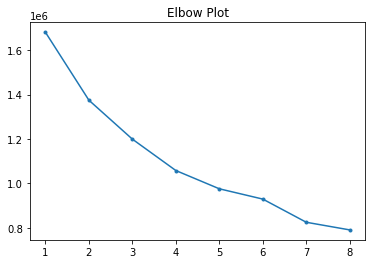

In [96]:
pd.Series(inertia_ls).plot(style='.-', title='Elbow Plot')
plt.xticks(range(8), range(1, 9));

In [97]:
inertia_ls

[1681131.0639095604,
 1374856.393070105,
 1199321.0239839773,
 1057852.8111040976,
 975577.7858206653,
 929147.82316261,
 824712.9727243655,
 790257.4806023329]

In [98]:
kmeans = MiniBatchKMeans(n_clusters=4, random_state=42)
ind_df_3_train['cluster'] = kmeans.fit_predict(ind_df_3_train_)

In [99]:
ind_df_3_train.groupby('cluster').describe().T

cluster                             0               1              2  \
name             count  294862.000000   179594.000000  237938.000000   
                 mean   445730.174478   444768.434168  445555.776723   
                 std    283519.498807   283206.952433  283694.128036   
                 min         1.000000        5.000000       3.000000   
                 25%    205354.250000   205386.500000  204836.500000   
                 50%    410527.500000   410049.500000  410149.500000   
                 75%    680513.000000   679018.500000  680729.750000   
                 max    999999.000000  1000000.000000  999997.000000   
idade            count  294862.000000   179594.000000  237938.000000   
                 mean       31.382962       31.296007      31.357875   
                 std        10.173869       10.143455      10.154754   
                 min        16.000000       16.000000      16.000000   
                 25%        24.000000       24.000000      24.000000   
                 50%        30.000000       30.000000      30.000000   
                 75%        37.000000       37.000000      37.000000   
                 max       111.000000      111.000000     124.000000   
qt_filhos        count  294862.000000   179594.000000  237938.000000   
                 mean        0.894251        0.899399       0.896871   
                 std         0.776149        0.777724       0.777531   
                 min         0.000000        0.000000       0.000000   
                 25%         0.000000        0.000000       0.000000   
                 50%         1.000000        1.000000       1.000000   
                 75%         2.000000        2.000000       2.000000   
                 max         2.000000        2.000000       2.000000   
estuda           count  294862.000000   179594.000000  237938.000000   
                 mean        0.400816        0.396008       0.398722   
                 std         0.480141        0.478858       0.479489   
                 min         0.000000        0.000000       0.000000   
                 25%         0.000000        0.000000       0.000000   
                 50%         0.000000        0.000000       0.000000   
                 75%         1.000000        1.000000       1.000000   
                 max         1.000000        1.000000       1.000000   
trabalha         count  294862.000000   179594.000000  237938.000000   
                 mean        0.822696        0.827053       0.823224   
                 std         0.381376        0.377588       0.380915   
                 min         0.000000        0.000000       0.000000   
                 25%         1.000000        1.000000       1.000000   
                 50%         1.000000        1.000000       1.000000   
                 75%         1.000000        1.000000       1.000000   
                 max         1.000000        1.000000       1.000000   
pratica_esportes count  294862.000000   179594.000000  237938.000000   
                 mean        0.601283        0.599377       0.599038   
                 std         0.451621        0.451822       0.452076   
                 min         0.000000        0.000000       0.000000   
                 25%         0.000000        0.000000       0.000000   
                 50%         1.000000        1.000000       1.000000   
                 75%         1.000000        1.000000       1.000000   
                 max         1.000000        1.000000       1.000000   
IMC              count  294862.000000   179594.000000  237938.000000   
                 mean       22.472507       22.446692      22.482955   
                 std         7.083179        7.068106       7.059303   
                 min         5.534848        5.376728       4.852828   
                 25%        17.418042       17.392141      17.444897   
                 50%        21.429564       21.415602      21.444402   
                 75%        26.363931   

In [100]:
ind_df_3_train.groupby('cluster')['idade_16mais'].value_counts(normalize=True)

cluster  idade_16mais
0        True            1.0
1        True            1.0
2        True            1.0
3        False           1.0
Name: idade_16mais, dtype: float64

In [101]:
ind_df_3_train.groupby('cluster')['estado_civil'].value_counts(normalize=True)

cluster  estado_civil
0        casado          0.459578
         divorciado      0.306455
         viuvo           0.153065
         outros          0.080902
1        solteiro        1.000000
2        solteiro        0.378729
         casado          0.285747
         divorciado      0.189163
         viuvo           0.095802
         outros          0.050559
3        solteiro        1.000000
Name: estado_civil, dtype: float64

In [102]:
ind_df_3_train.groupby('cluster')['transporte_mais_utilizado'].value_counts(normalize=True)

cluster  transporte_mais_utilizado
0        publico                      0.862854
         taxi                         0.072112
         outros                       0.065034
1        publico                      0.863793
         taxi                         0.071617
         outros                       0.064590
2        particular                   1.000000
3        publico                      0.571503
         particular                   0.336600
         taxi                         0.049218
         outros                       0.042679
Name: transporte_mais_utilizado, dtype: float64

A partir dos dados observados acima, a identificação do perfil de cada cluster é quase imediata:

* cluster 0 = acima de 16 anos, não solteiros e transporte mais utilizado diferente de particular
* cluster 1 = acima de 16 anos, solteiros e transporte mais utilizado diferente de particular
* cluster 2 = acima de 16 anos e transporte mais utilizado é o particular
* cluster 3 = abaixo de 16 anos

Observe que neste caso a variável cluster é categórica nominal.

In [103]:
cluster_to_label = {0: 'nao_solteiro, nao_transp_part',
                    1: 'solteiro, nao_transp_part',
                    2: 'transp_particular',
                    3: 'idade_ate16'}

ind_df_3_train['cluster'].replace(cluster_to_label, inplace=True)
ind_df_3_train.drop('idade_16mais', axis=1, inplace=True)

In [104]:
ind_df_3_train.index = ind_train_index

ind_df_3_train

,name,idade,estado_civil,qt_filhos,estuda,trabalha,pratica_esportes,transporte_mais_utilizado,IMC,cluster
0,1,44.0,divorciado,1.0,1.0,0.0,1.000000,publico,22.200956,"nao_solteiro, nao_transp_part"
1,2,24.0,casado,0.0,0.0,1.0,1.000000,publico,25.378720,"nao_solteiro, nao_transp_part"
2,3,35.0,solteiro,1.0,0.0,1.0,1.000000,particular,19.952393,transp_particular
3,4,50.0,casado,1.0,1.0,1.0,0.000000,publico,26.732053,"nao_solteiro, nao_transp_part"
4,5,30.0,solteiro,2.0,1.0,1.0,1.000000,publico,15.295668,"solteiro, nao_transp_part"
...,...,...,...,...,...,...,...,...,...,...
999994,999995,33.0,casado,0.0,0.0,1.0,0.599823,particular,16.982246,transp_particular
999995,999996,34.0,casado,1.0,0.0,1.0,1.000000,publico,17.556771,"nao_solteiro, nao_transp_part"
999996,999997,40.0,casado,1.0,0.0,1.0,1.000000,particular,24.848402,transp_particular
999998,999999,33.0,casado,0.0,1.0,1.0,1.000000,publico,16.979569,"nao_solteiro, nao_transp_part"


### Feature engineering `conn_df`

A próxima feature a ser criada decorre da concatenação de `grau` com `proximidade`, e nos dá informação sobre o tipo de relação existente entre doente e saudável. No total são 12 tipos de relações, e a hipótese neste caso é de que diferentes tipos de relações possivelmente estejam correlacionadas com diferentes taxas médias de contaminação. Relações com taxas de contaminação similares foram agrupadas em clusters.

In [105]:
conn_df_3 = (df_2[['name_V1', 'name_V2', 'grau', 'proximidade', 'prob_V1_V2']]
             .copy(deep=True)
             .rename({'name_V1': 'V1', 'name_V2': 'V2'}, axis=1))

In [106]:
conn_df_3_train = conn_df_3.loc[df_train_index]

In [107]:
conn_df_3_train['relacao'] = conn_df_3_train['grau'].str.cat(conn_df_3_train['proximidade'], sep=', ')

relacao_ls = sorted(conn_df_3_train['relacao'].unique())

conn_df_3_train['relacao'].value_counts(normalize=True)

trabalho, visita_rara         0.134119
familia, visita_rara          0.133805
amigos, visita_rara           0.133074
trabalho, visita_casual       0.100002
amigos, visita_casual         0.099907
familia, visita_casual        0.099412
trabalho, visita_frequente    0.066860
amigos, visita_frequente      0.066513
familia, visita_frequente     0.066152
amigos, mora_junto            0.033667
familia, mora_junto           0.033448
trabalho, mora_junto          0.033042
Name: relacao, dtype: float64

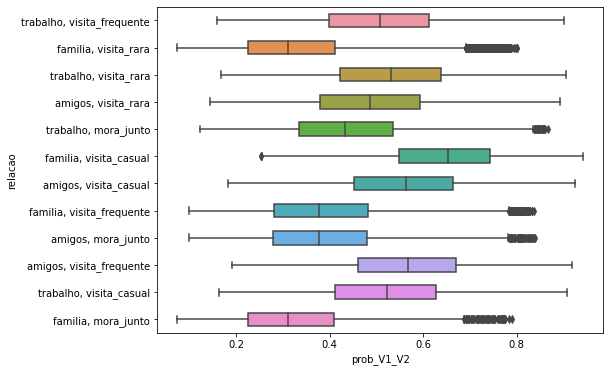

In [108]:
fig = plt.figure(figsize=(8, 6))
sns.boxplot(x='prob_V1_V2', y='relacao', data=conn_df_3_train, width=0.5);

A partir deste ponto, inciamos um método iterativo para agrupar em clusters relações que tenham taxas de contaminação similares, com base na mediana, ao mesmo tempo em que tentamos maximizar a diferença entre as taxas médias de contaminação em cada cluster.

In [109]:
(conn_df_3_train
 .drop(['V1', 'V2'], axis=1)
 .groupby('relacao')
 .describe()
 .sort_values(('prob_V1_V2', '50%')))

prob_V1_V2                                          \
                                count      mean       std       min       25%   
relacao                                                                         
familia, mora_junto           20069.0  0.322779  0.125863  0.074913  0.225531   
familia, visita_rara          80283.0  0.323961  0.127555  0.074462  0.225620   
amigos, mora_junto            20200.0  0.384829  0.136261  0.099979  0.279684   
familia, visita_frequente     39691.0  0.386003  0.135941  0.098708  0.281577   
trabalho, mora_junto          19825.0  0.437405  0.137729  0.123167  0.335149   
amigos, visita_rara           79844.0  0.486472  0.143317  0.144295  0.379882   
trabalho, visita_frequente    40116.0  0.505055  0.142320  0.158630  0.398199   
trabalho, visita_casual       60001.0  0.518767  0.143013  0.163618  0.411830   
trabalho, visita_rara         80471.0  0.528199  0.142872  0.168599  0.422530   
amigos, visita_casual         59944.0  0.556082  0.141184  0.183379  0.452634   
amigos, visita_frequente      39908.0  0.562461  0.140548  0.191149  0.460041   
familia, visita_casual        59647.0  0.640427  0.132531  0.253823  0.548531   

                                                          
                                 50%       75%       max  
relacao                                                   
familia, mora_junto         0.311021  0.410166  0.790090  
familia, visita_rara        0.311445  0.412038  0.801585  
amigos, mora_junto          0.376742  0.481094  0.839697  
familia, visita_frequente   0.377092  0.482420  0.836860  
trabalho, mora_junto        0.432721  0.536097  0.866738  
amigos, visita_rara         0.486014  0.594477  0.893303  
trabalho, visita_frequente  0.506930  0.613382  0.901359  
trabalho, visita_casual     0.522451  0.627672  0.907455  
trabalho, visita_rara       0.531596  0.637671  0.906223  
amigos, visita_casual       0.562586  0.664134  0.925766  
amigos, visita_frequente    0.568854  0.669765  0.918578  
familia, visita_casual      0.653014  0.744022  0.942116

In [110]:
cluster_0 = ['familia, visita_rara', 'familia, mora_junto']
cluster_1 = ['familia, visita_frequente', 'amigos, mora_junto']
cluster_2 = ['trabalho, mora_junto']
cluster_3 = ['amigos, visita_rara', 'trabalho, visita_frequente',
             'trabalho, visita_casual', 'trabalho, visita_rara']
cluster_4 = ['amigos, visita_casual', 'amigos, visita_frequente', 'familia, visita_casual']

conn_df_3_train['risco_relacao'] = 0
conn_df_3_train.loc[conn_df_3_train['relacao'].isin(cluster_1), 'risco_relacao'] = 1
conn_df_3_train.loc[conn_df_3_train['relacao'].isin(cluster_2), 'risco_relacao'] = 2
conn_df_3_train.loc[conn_df_3_train['relacao'].isin(cluster_3), 'risco_relacao'] = 3
conn_df_3_train.loc[conn_df_3_train['relacao'].isin(cluster_4), 'risco_relacao'] = 4

In [111]:
conn_df_3_train['risco_relacao'].value_counts(normalize=True)

3    0.434054
4    0.265832
0    0.167254
1    0.099818
2    0.033042
Name: risco_relacao, dtype: float64

In [112]:
(conn_df_3_train
 .drop(['V1', 'V2'], axis=1)
 .groupby('risco_relacao')
 .describe()
 .sort_values(('prob_V1_V2', '50%')))

prob_V1_V2                                                    \
                   count      mean       std       min       25%       50%   
risco_relacao                                                                
0               100352.0  0.323725  0.127218  0.074462  0.225605  0.311365   
1                59891.0  0.385607  0.136049  0.098708  0.280976  0.376982   
2                19825.0  0.437405  0.137729  0.123167  0.335149  0.432721   
3               260432.0  0.509668  0.143978  0.144295  0.402939  0.511464   
4               159499.0  0.589220  0.143439  0.183379  0.487621  0.594734   

                                   
                    75%       max  
risco_relacao                      
0              0.411682  0.801585  
1              0.482000  0.839697  
2              0.536097  0.866738  
3              0.618038  0.907455  
4              0.696442  0.942116

In [113]:
cluster_1 = cluster_1 + cluster_2
cluster_2, cluster_3 = cluster_3, cluster_4

conn_df_3_train['risco_relacao'].replace({2: 1, 3: 2, 4: 3}, inplace=True)

In [114]:
conn_df_3_train['risco_relacao'].value_counts(normalize=True)

2    0.434054
3    0.265832
0    0.167254
1    0.132860
Name: risco_relacao, dtype: float64

In [115]:
(conn_df_3_train
 .drop(['V1', 'V2'], axis=1)
 .groupby('risco_relacao')
 .describe()
 .sort_values(('prob_V1_V2', '50%')))

prob_V1_V2                                                    \
                   count      mean       std       min       25%       50%   
risco_relacao                                                                
0               100352.0  0.323725  0.127218  0.074462  0.225605  0.311365   
1                79716.0  0.398489  0.138293  0.098708  0.292685  0.389893   
2               260432.0  0.509668  0.143978  0.144295  0.402939  0.511464   
3               159499.0  0.589220  0.143439  0.183379  0.487621  0.594734   

                                   
                    75%       max  
risco_relacao                      
0              0.411682  0.801585  
1              0.495264  0.866738  
2              0.618038  0.907455  
3              0.696442  0.942116

In [116]:
cluster_0 = cluster_0 + cluster_1
cluster_1, cluster_2 = cluster_2, cluster_3

conn_df_3_train['risco_relacao'].replace({1: 0, 2: 1, 3: 2}, inplace=True)

conn_df_3_train['risco_relacao'] = pd.Categorical(conn_df_3_train['risco_relacao'],
                                                  categories=[0, 1, 2],
                                                  ordered=True)

In [117]:
conn_df_3_train['risco_relacao'].unique()

[1, 0, 2]
Categories (3, int64): [0 < 1 < 2]

In [118]:
conn_df_3_train['risco_relacao'].value_counts(normalize=True)

1    0.434054
0    0.300114
2    0.265832
Name: risco_relacao, dtype: float64

In [119]:
(conn_df_3_train
 .drop(['V1', 'V2'], axis=1)
 .groupby('risco_relacao')
 .describe()
 .sort_values(('prob_V1_V2', '50%')))

prob_V1_V2                                                    \
                   count      mean       std       min       25%       50%   
risco_relacao                                                                
0               180068.0  0.356823  0.137351  0.074462  0.252082  0.343215   
1               260432.0  0.509668  0.143978  0.144295  0.402939  0.511464   
2               159499.0  0.589220  0.143439  0.183379  0.487621  0.594734   

                                   
                    75%       max  
risco_relacao                      
0              0.448880  0.866738  
1              0.618038  0.907455  
2              0.696442  0.942116

Assim ficaram os clusters finais:

* cluster 0 = 'familia, visita_rara', 'trabalho, mora_junto', 'familia, visita_frequente', 'amigos, mora_junto', 'familia, mora_junto';
* cluster 1 = 'trabalho, visita_frequente', 'trabalho, visita_rara', 'amigos, visita_rara', 'trabalho, visita_casual';
* cluster 2 = 'familia, visita_casual', 'amigos, visita_casual', 'amigos, visita_frequente'.

Já neste caso, o cluster constitui uma variável categórica ordinal, em que o número do cluster tem uma relação direta com a sua taxa média de contaminação.

In [120]:
conn_df_3_train.drop('relacao', axis=1, inplace=True)

conn_df_3_train

,V1,V2,grau,proximidade,prob_V1_V2,risco_relacao
333136,166569,333138,trabalho,visita_frequente,0.567904,1
515905,257953,515907,trabalho,visita_frequente,0.480014,1
230477,115239,230479,familia,visita_rara,0.385742,0
967321,483661,967323,trabalho,visita_rara,0.436102,1
610942,305472,610944,amigos,visita_rara,0.496274,1
...,...,...,...,...,...,...
259178,129590,259180,amigos,mora_junto,0.480588,0
365838,182920,365840,familia,visita_casual,0.542663,2
131932,65967,131934,trabalho,visita_casual,0.583405,1
671155,335578,671157,trabalho,visita_frequente,0.448263,1


<AxesSubplot:xlabel='risco_relacao', ylabel='prob_V1_V2'>

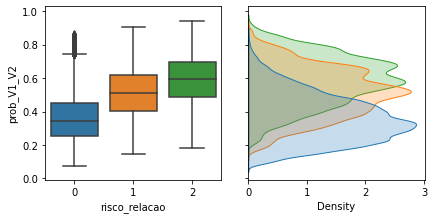

In [121]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), sharey=True)
fig.tight_layout()

sns.kdeplot(y='prob_V1_V2',
            hue='risco_relacao',
            common_norm=False,
            legend=False,
            fill=True,
            data=conn_df_3_train,
            ax=ax[1])
sns.boxplot(y='prob_V1_V2', x='risco_relacao', data=conn_df_3_train, ax=ax[0])

# plt.savefig('../data/images/risco_relacao.png', bbox_inches='tight');

In [122]:
df_3_train = create_df(ind_df_3_train, conn_df_3_train)

In [123]:
df_V1 = df_3_train.filter(regex='V1|relacao', axis=1).drop(['name_V1', 'prob_V1_V2'], axis=1)
df_V1.rename(lambda x: x.rstrip('_V1'), axis=1, inplace=True)
df_V1['suffix'] = 'V1'
df_V2 = df_3_train.filter(regex='V2|relacao', axis=1).drop(['name_V2', 'prob_V1_V2'], axis=1)
df_V2.rename(lambda x: x.rstrip('_V2'), axis=1, inplace=True)
df_V2['suffix'] = 'V2'

df_V1_V2 = df_V1.append(df_V2)

In [124]:
df_V1_V2.groupby(['suffix', 'risco_relacao']).describe().T

suffix                             V1                                \
risco_relacao                       0              1              2   
idade            count  180068.000000  260432.000000  159499.000000   
                 mean       30.009158      29.982318      29.953266   
                 std        10.967800      10.965503      10.947142   
                 min         1.000000       1.000000       0.000000   
                 25%        22.000000      22.000000      22.000000   
                 50%        29.000000      29.000000      29.000000   
                 75%        37.000000      37.000000      37.000000   
                 max       103.000000     111.000000     110.000000   
qt_filhos        count  180068.000000  260432.000000  159499.000000   
                 mean        0.830935       0.832601       0.835490   
                 std         0.783610       0.782228       0.784515   
                 min         0.000000       0.000000       0.000000   
                 25%         0.000000       0.000000       0.000000   
                 50%         1.000000       1.000000       1.000000   
                 75%         1.000000       1.000000       1.000000   
                 max         2.000000       2.000000       2.000000   
estuda           count  180068.000000  260432.000000  159499.000000   
                 mean        0.442089       0.441183       0.442815   
                 std         0.487550       0.487511       0.487599   
                 min         0.000000       0.000000       0.000000   
                 25%         0.000000       0.000000       0.000000   
                 50%         0.000000       0.000000       0.000000   
                 75%         1.000000       1.000000       1.000000   
                 max         1.000000       1.000000       1.000000   
trabalha         count  180068.000000  260432.000000  159499.000000   
                 mean        0.818890       0.818892       0.816624   
                 std         0.384772       0.384736       0.386600   
                 min         0.000000       0.000000       0.000000   
                 25%         1.000000       1.000000       1.000000   
                 50%         1.000000       1.000000       1.000000   
                 75%         1.000000       1.000000       1.000000   
                 max         1.000000       1.000000       1.000000   
pratica_esportes count  180068.000000  260432.000000  159499.000000   
                 mean        0.598670       0.600133       0.600612   
                 std         0.452342       0.451748       0.451811   
                 min         0.000000       0.000000       0.000000   
                 25%         0.000000       0.000000       0.000000   
                 50%         1.000000       1.000000       1.000000   
                 75%         1.000000       1.000000       1.000000   
                 max         1.000000       1.000000       1.000000   
IMC              count  180068.000000  260432.000000  159499.000000   
                 mean       22.456095      22.452314      22.441415   
                 std         7.066223       7.083328       7.057049   
                 min         5.376728       5.534848       5.376728   
                 25%        17.412393      17.400337      17.416845   
                 50%        21.420540      21.406861      21.408326   
                 75%        26.365826      26.358304      26.361456   
                 max        89.158204      84.681985      89.158204   

suffix                             V2                                
risco_relacao                       0              1              2  
idade            count  180068.000000  260432.000000  159499.000000  
                 mean       30.013095      29.993929      29.967899  
                 std        10.932771      10.977157      10.973815  
                 min         1.000000       0.000000       0.000000  
                 25%        2

In [125]:
X_3_train = pd.get_dummies(df_3_train.drop(cols_to_drop, axis=1), drop_first=True)
y_3_train = logit(df_3_train['prob_V1_V2'])

lr_3_model = LinearRegression().fit(X_3_train, y_3_train)

In [126]:
ind_df_3_test = ind_df_3.loc[ind_test_index]

ind_df_3_test_ = scaler.transform(pd.get_dummies(ind_df_3_test.drop('name', axis=1)))

ind_df_3_test['cluster'] = kmeans.predict(ind_df_3_test_)

ind_df_3_test['cluster'].replace(cluster_to_label, inplace=True)
ind_df_3_test.drop('idade_16mais', axis=1, inplace=True)

In [127]:
conn_df_3_test = conn_df_3.loc[df_test_index]

conn_df_3_test['relacao'] = conn_df_3_test['grau'].str.cat(conn_df_3_test['proximidade'], sep=', ')

conn_df_3_test['risco_relacao'] = 0
conn_df_3_test.loc[conn_df_3_test['relacao'].isin(cluster_1), 'risco_relacao'] = 1
conn_df_3_test.loc[conn_df_3_test['relacao'].isin(cluster_2), 'risco_relacao'] = 2

conn_df_3_test['risco_relacao'] = pd.Categorical(conn_df_3_test['risco_relacao'],
                                                 categories=[0, 1, 2],
                                                 ordered=True)

conn_df_3_test.drop('relacao', axis=1, inplace=True)

In [128]:
df_3_test = create_df(ind_df_3_test, conn_df_3_test)

In [129]:
X_3_test = pd.get_dummies(df_3_test.drop(cols_to_drop, axis=1), drop_first=True)
y_3_test = logit(df_3_test['prob_V1_V2'])

In [130]:
train_loss = cross_entropy_loss(y_3_train, lr_3_model.predict(X_3_train))
test_loss = cross_entropy_loss(y_3_test, lr_3_model.predict(X_3_test))

print('lr_3 train loss:', train_loss)
print('lr_3 test loss:', test_loss)

lr_3 train loss: 0.6482013219451016
lr_3 test loss: 0.6483795181647798


In [131]:
ind_df_3 = (pd
            .concat([ind_df_3_train, ind_df_3_test],
                    axis=0,
                    ignore_index=True)
            .drop_duplicates()
            .sort_values('name')
            .reset_index(drop=True))

ind_df_3['cluster'].replace({'nao_solteiro, nao_transp_part': 'ns_ntp',
                             'solteiro, nao_transp_part': 's_ntp',
                             'transp_particular': 'tp',
                             'idade_ate16': 'i_a16'}, inplace=True)

In [132]:
conn_df_3 = (pd
             .concat([conn_df_3_train, conn_df_3_test],
                     axis=0,
                     ignore_index=True)
             .sort_values(['V1', 'V2'])
             .reset_index(drop=True))

In [133]:
df_3 = (pd
        .concat([df_3_train, df_3_test],
                axis=0,
                ignore_index=True)
        .sort_values(['name_V1', 'name_V2'])
        .reset_index(drop=True))

df_3.replace({'nao_solteiro, nao_transp_part': 'ns_ntp',
              'solteiro, nao_transp_part': 's_ntp',
              'transp_particular': 'tp',
              'idade_ate16': 'i_a16'}, inplace=True)

## LightGBM Regressor

Esta estratégia, dentre todas as utilizadas, é certamente a mais eficiente, pois não há necessidade de se preocupar em imputar os missing values. E mais do que isso, é um modelo que consegue capturar relações não-lineares entre as features, e ainda utiliza o fato de que existem missing values como informação para o treinamento e otimização da performance. Tamanha a complexidade deste modelo acaba por resultar em uma difícil interpretação da relação entre e as features e o target.

In [134]:
df_4 = pd.get_dummies(df_raw.drop(['name_V1', 'name_V2'], axis=1), drop_first=True)
X_4, y_4 = df_4.drop('prob_V1_V2', axis=1), df_4['prob_V1_V2']
X_4_train, X_4_test, y_4_train, y_4_test = train_test_split(X_4,
                                                            logit(y_4),
                                                            test_size=0.4,
                                                            random_state=42)

In [135]:
lgbm_reg = lgb.LGBMRegressor(random_state=42)
lgbm_reg.fit(X_4_train, y_4_train);

In [136]:
train_loss = cross_entropy_loss(y_4_train, lgbm_reg.predict(X_4_train))
test_loss = cross_entropy_loss(y_4_test, lgbm_reg.predict(X_4_test))

print('lgbr train loss:', train_loss)
print('lgbr test loss:', test_loss)

lgbr train loss: 0.6489607855872174
lgbr test loss: 0.6490465650369334


# Estimando a taxa de contaminação para o resto da população

Feitas todas as considerações acima, optamos pela utilização do Modelo 3 por se tratar do melhor, dentre os analisados, quando ponderados os fatores: interpretabilidade, custo de modelagem e performance.

In [137]:
df_half = df_3.copy(deep=True)

In [138]:
df_half

,name_V1,idade_V1,estado_civil_V1,qt_filhos_V1,estuda_V1,trabalha_V1,pratica_esportes_V1,transporte_mais_utilizado_V1,IMC_V1,cluster_V1,...,estuda_V2,trabalha_V2,pratica_esportes_V2,transporte_mais_utilizado_V2,IMC_V2,cluster_V2,grau,proximidade,prob_V1_V2,risco_relacao
0,1,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956,ns_ntp,...,0.0,1.0,1.0,publico,25.378720,ns_ntp,trabalho,visita_frequente,0.589462,1
1,1,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956,ns_ntp,...,0.0,1.0,1.0,particular,19.952393,tp,trabalho,visita_rara,0.708465,1
2,2,24.0,casado,0.0,0.0,1.0,1.0,publico,25.378720,ns_ntp,...,1.0,1.0,0.0,publico,26.732053,ns_ntp,trabalho,visita_casual,0.602863,1
3,2,24.0,casado,0.0,0.0,1.0,1.0,publico,25.378720,ns_ntp,...,1.0,1.0,1.0,publico,15.295668,s_ntp,trabalho,visita_rara,0.638842,1
4,3,35.0,solteiro,1.0,0.0,1.0,1.0,particular,19.952393,tp,...,0.0,1.0,0.0,publico,20.412942,ns_ntp,amigos,mora_junto,0.232270,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999994,499998,23.0,casado,0.0,1.0,1.0,0.0,publico,22.036885,ns_ntp,...,0.0,1.0,1.0,publico,17.556771,ns_ntp,trabalho,visita_rara,0.462184,1
999995,499998,23.0,casado,0.0,1.0,1.0,0.0,publico,22.036885,ns_ntp,...,0.0,1.0,1.0,particular,24.848402,tp,trabalho,visita_rara,0.538457,1
999996,499999,26.0,casado,2.0,0.0,1.0,0.0,taxi,19.543889,ns_ntp,...,0.0,1.0,1.0,publico,23.829635,ns_ntp,familia,visita_casual,0.451662,2
999997,499999,26.0,casado,2.0,0.0,1.0,0.0,taxi,19.543889,ns_ntp,...,1.0,1.0,1.0,publico,16.979569,ns_ntp,familia,visita_rara,0.186973,0


In [139]:
rev_cols = ['V2', 'V1', 'grau', 'proximidade', 'risco_relacao']
rev_conn_df = conn_df_3[rev_cols].copy(deep=True).rename(columns={'V1': 'V2', 'V2': 'V1'})
rev_conn_df['prob_V1_V2'] = np.nan

In [140]:
df_other_half = create_df(ind_df_3, conn_df_3)

In [141]:
X_other_half = df_other_half.drop(cols_to_drop, axis=1)
X_other_half = pd.get_dummies(X_other_half, drop_first=True)

In [142]:
lr_model = lr_3_model

In [143]:
df_other_half['prob_V1_V2'] = sigmoid(lr_model.predict(X_other_half))

In [144]:
df = df_half.append(df_other_half, ignore_index=True).drop(['name_V1', 'name_V2'], axis=1)

cols = ['idade_V1', 'qt_filhos_V1', 'estuda_V1', 'trabalha_V1', 'pratica_esportes_V1',
        'idade_V2', 'qt_filhos_V2', 'estuda_V2', 'trabalha_V2', 'pratica_esportes_V2']

df[cols] = df[cols].round()

In [145]:
df

,idade_V1,estado_civil_V1,qt_filhos_V1,estuda_V1,trabalha_V1,pratica_esportes_V1,transporte_mais_utilizado_V1,IMC_V1,cluster_V1,idade_V2,...,estuda_V2,trabalha_V2,pratica_esportes_V2,transporte_mais_utilizado_V2,IMC_V2,cluster_V2,grau,proximidade,prob_V1_V2,risco_relacao
0,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956,ns_ntp,24.0,...,0.0,1.0,1.0,publico,25.378720,ns_ntp,trabalho,visita_frequente,0.589462,1
1,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956,ns_ntp,35.0,...,0.0,1.0,1.0,particular,19.952393,tp,trabalho,visita_rara,0.708465,1
2,24.0,casado,0.0,0.0,1.0,1.0,publico,25.378720,ns_ntp,50.0,...,1.0,1.0,0.0,publico,26.732053,ns_ntp,trabalho,visita_casual,0.602863,1
3,24.0,casado,0.0,0.0,1.0,1.0,publico,25.378720,ns_ntp,30.0,...,1.0,1.0,1.0,publico,15.295668,s_ntp,trabalho,visita_rara,0.638842,1
4,35.0,solteiro,1.0,0.0,1.0,1.0,particular,19.952393,tp,20.0,...,0.0,1.0,0.0,publico,20.412942,ns_ntp,amigos,mora_junto,0.232270,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999993,23.0,casado,0.0,1.0,1.0,0.0,publico,22.036885,ns_ntp,34.0,...,0.0,1.0,1.0,publico,17.556771,ns_ntp,trabalho,visita_rara,0.405089,1
1999994,23.0,casado,0.0,1.0,1.0,0.0,publico,22.036885,ns_ntp,40.0,...,0.0,1.0,1.0,particular,24.848402,tp,trabalho,visita_rara,0.522895,1
1999995,26.0,casado,2.0,0.0,1.0,0.0,taxi,19.543889,ns_ntp,30.0,...,0.0,1.0,1.0,publico,23.829635,ns_ntp,familia,visita_casual,0.434115,2
1999996,26.0,casado,2.0,0.0,1.0,0.0,taxi,19.543889,ns_ntp,33.0,...,1.0,1.0,1.0,publico,16.979569,ns_ntp,familia,visita_rara,0.181235,0


## Feature importance

In [146]:
scaler = StandardScaler()

xentropy_loss = make_scorer(cross_entropy_loss, greater_is_better=False)

feats_imp = permutation_importance(lr_model,
                                   scaler.fit_transform(X_3_train),
                                   y_3_train,
                                   scoring=xentropy_loss,
                                   n_jobs=-1,
                                   random_state=42)

In [147]:
coefs_imp = (pd.
             DataFrame({'coefs': X_3_train.columns,
                        'avg_imp': feats_imp.importances_mean,
                        'std_imp': feats_imp.importances_std})
             .sort_values('avg_imp',
                          ascending=False,
                          key=lambda x: abs(x),
                          ignore_index=True))

coefs_imp[:10]

,coefs,avg_imp,std_imp
0,"cluster_V1_nao_solteiro, nao_transp_part",0.260411,0.000582
1,estado_civil_V1_solteiro,0.220166,0.000349
2,risco_relacao_2,0.170279,0.000183
3,risco_relacao_1,0.101043,0.000120
4,transporte_mais_utilizado_V1_particular,0.081285,0.000067
5,pratica_esportes_V1,0.030291,0.000182
6,estado_civil_V1_viuvo,0.026306,0.000191
7,proximidade_visita_casual,0.018165,0.000026
8,grau_familia,0.012072,0.000031
9,trabalha_V1,0.008555,0.000037


## EDA

No que se segue abaixo, fiz algums observações sobre insights pontuais que considerei mais interessantes.

In [148]:
df['prob_V1_V2'].describe().T

count    1.999998e+06
mean     4.849809e-01
std      1.592408e-01
min      7.446164e-02
25%      3.646501e-01
50%      4.879014e-01
75%      6.051051e-01
max      9.422452e-01
Name: prob_V1_V2, dtype: float64

In [149]:
prob_mean = df['prob_V1_V2'].mean()
prob_std = df['prob_V1_V2'].std()

(0.0, 1.0)

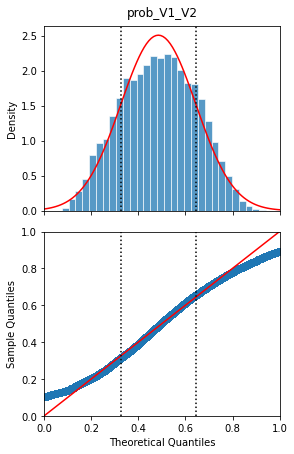

In [150]:
fig, ax = plt.subplots(2, 1, figsize=(4, 6), sharex=True)
fig.tight_layout()

ax[0].set_title('prob_V1_V2', pad=10)
x = np.linspace(0, 1, 100)
ax[0].plot(x, stats.norm.pdf(x, loc=prob_mean, scale=prob_std), color='red')
ax[0].axvline(prob_mean - prob_std, color='black', linestyle=':')
ax[0].axvline(prob_mean + prob_std, color='black', linestyle=':')

x = np.linspace(df['prob_V1_V2'].min(), df['prob_V1_V2'].max(), 100)
sns.histplot(x='prob_V1_V2', stat='density', data=df, bins=30, edgecolor='white', ax=ax[0])

sm.qqplot(df['prob_V1_V2'], loc=prob_mean, scale=prob_std, line='45', ax=ax[1])
ax[1].axvline(prob_mean - prob_std, color='black', linestyle=':')
ax[1].axvline(prob_mean + prob_std, color='black', linestyle=':')

plt.xlim(0, 1)
plt.ylim(0, 1)

# plt.savefig('../data/images/prob_normal.png', bbox_inches='tight');

* Distribuição da taxa de contaminação é aproximadamente Normal, como se pode notar nas comparações com as representações das distribuições teóricas em vermelho. As linhas pontilhadas acima demarcam `média - 1dp` e `média + 1dp`.
* Criação de uma nova variável `risco_contaminação` com três classes:
    -  (0) baixo risco $\longleftrightarrow$ abaixo de `média - 1dp`
    -  (1) médio risco $\longleftrightarrow$ entre `média - 1dp` e `média + 1dp`
    -  (2) alto risco $\longleftrightarrow$ acima  de `média + 1dp`

In [151]:
df['risco_contaminacao'] = 1
df.loc[df['prob_V1_V2'] < prob_mean - prob_std, 'risco_contaminacao'] = 0
df.loc[df['prob_V1_V2'] > prob_mean + prob_std, 'risco_contaminacao'] = 2

In [152]:
df['risco_contaminacao'].value_counts(normalize=True)

1    0.645368
0    0.177407
2    0.177226
Name: risco_contaminacao, dtype: float64

In [153]:
df.groupby('risco_contaminacao').apply(lambda x: x.describe().T)

count       mean        std  \
risco_contaminacao                                                        
0                  idade_V1              354813.0  30.676387  10.593321   
                   qt_filhos_V1          354813.0   0.860450   0.780348   
                   estuda_V1             354813.0   0.361472   0.480428   
                   trabalha_V1           354813.0   0.904285   0.294201   
                   pratica_esportes_V1   354813.0   0.413514   0.492464   
                   IMC_V1                354813.0  22.432407   7.050692   
                   idade_V2              354813.0  30.196926  10.999405   
                   qt_filhos_V2          354813.0   0.835795   0.783532   
                   estuda_V2             354813.0   0.426825   0.494617   
                   trabalha_V2           354813.0   0.753149   0.431180   
                   pratica_esportes_V2   354813.0   0.660652   0.473489   
                   IMC_V2                354813.0  22.304552   6.986609   
                   prob_V1_V2            354813.0   0.249972   0.054887   
                   risco_contaminacao    354813.0   0.000000   0.000000   
1                  idade_V1             1290734.0  30.102573  10.925631   
                   qt_filhos_V1         1290734.0   0.841200   0.783404   
                   estuda_V1            1290734.0   0.421829   0.493852   
                   trabalha_V1          1290734.0   0.830372   0.375306   
                   pratica_esportes_V1  1290734.0   0.664490   0.472169   
                   IMC_V1               1290734.0  22.469446   7.081441   
                   idade_V2             1290734.0  30.006463  10.964746   
                   qt_filhos_V2         1290734.0   0.836678   0.784080   
                   estuda_V2            1290734.0   0.427269   0.494682   
                   trabalha_V2          1290734.0   0.750378   0.432795   
                   pratica_esportes_V2  1290734.0   0.659313   0.473940   
                   IMC_V2               1290734.0  22.457674   7.064595   
                   prob_V1_V2           1290734.0   0.486433   0.089183   
                   risco_contaminacao   1290734.0   1.000000   0.000000   
2                  idade_V1              354451.0  28.902130  11.400630   
                   qt_filhos_V1          354451.0   0.789412   0.785695   
                   estuda_V1             354451.0   0.515406   0.499763   
                   trabalha_V1           354451.0   0.687776   0.463401   
                   pratica_esportes_V1   354451.0   0.888907   0.314248   
                   IMC_V1                354451.0  22.471769   7.087783   
                   idade_V2              354451.0  29.749545  10.916025   
                   qt_filhos_V2          354451.0   0.829847   0.784169   
                   estuda_V2             354451.0   0.428544   0.494868   
                   trabalha_V2           354451.0   0.747158   0.434642   
                   pratica_esportes_V2   354451.0   0.659019   0.474040   
                   IMC_V2                354451.0  22.690974   7.183603   
                   prob_V1_V2            354451.0   0.714942   0.054100   
                   risco_contaminacao    354451.0   2.000000   0.000000   

                                             min        25%        50%  \
risco_contaminacao                                                       
0                  idade_V1             2.000000  23.000000  29.000000   
                   qt_filhos_V1         0.000000   0.000000   1.000000   
                   estuda_V1            0.000000   0.000000   0.000000   
                   trabalha_V1          0.000000   1.000000   1.000000   
                   pratica_esportes_V1  0.000000   0.000000   0.000000   
                   IMC_V1               5.376728  17.390888  21.393960   
                   idade_V2             1.000000  22.000000  29.000000   
                   qt_filhos_V2         0.000000   0.000000   1.000000   
   

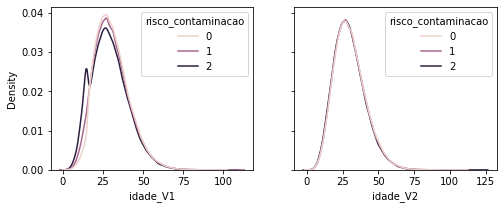

In [154]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

sns.kdeplot(x='idade_V1', hue='risco_contaminacao', data=df, common_norm=False, ax=ax[0])
sns.kdeplot(x='idade_V2', hue='risco_contaminacao', data=df, common_norm=False, ax=ax[1]);

Para saudáveis, a distribuição de idade é a mesma independente de `risco_contaminacao`, ao contrário do que ocorre com doentes, em particular quando `risco_contaminacao = 2`. Neste caso, a probabilidade de a idade ser inferior a 16 anos é notavelmente superior quando comparado com os demais valores de `risco_contaminacao`. Sendo assim, vamos investigar mais a fundo o impacto disto nas demais variáveis. Em particular, queremos entender melhor as diferenças (e similaridades) entre os perfis das pessoas doentes que compõem cada grupo de `risco_contaminacao`.

In [155]:
df['idade_V1_16mais'], df.loc[df['idade_V1'] < 16, 'idade_V1_16mais'] = True, False
df['idade_V2_16mais'], df.loc[df['idade_V2'] < 16, 'idade_V2_16mais'] = True, False

mask_1, mask_2 = df['idade_V1_16mais'], df['idade_V2_16mais']

cols_1 = ['estado_civil_V1', 'qt_filhos_V1', 'estuda_V1', 'trabalha_V1',
          'pratica_esportes_V1', 'transporte_mais_utilizado_V1', 'cluster_V1']

cols_2 = ['estado_civil_V2', 'qt_filhos_V2',  'estuda_V2', 'trabalha_V2',
          'pratica_esportes_V2', 'transporte_mais_utilizado_V2', 'cluster_V2']

Text(311.49090909090904, 0.5, '')

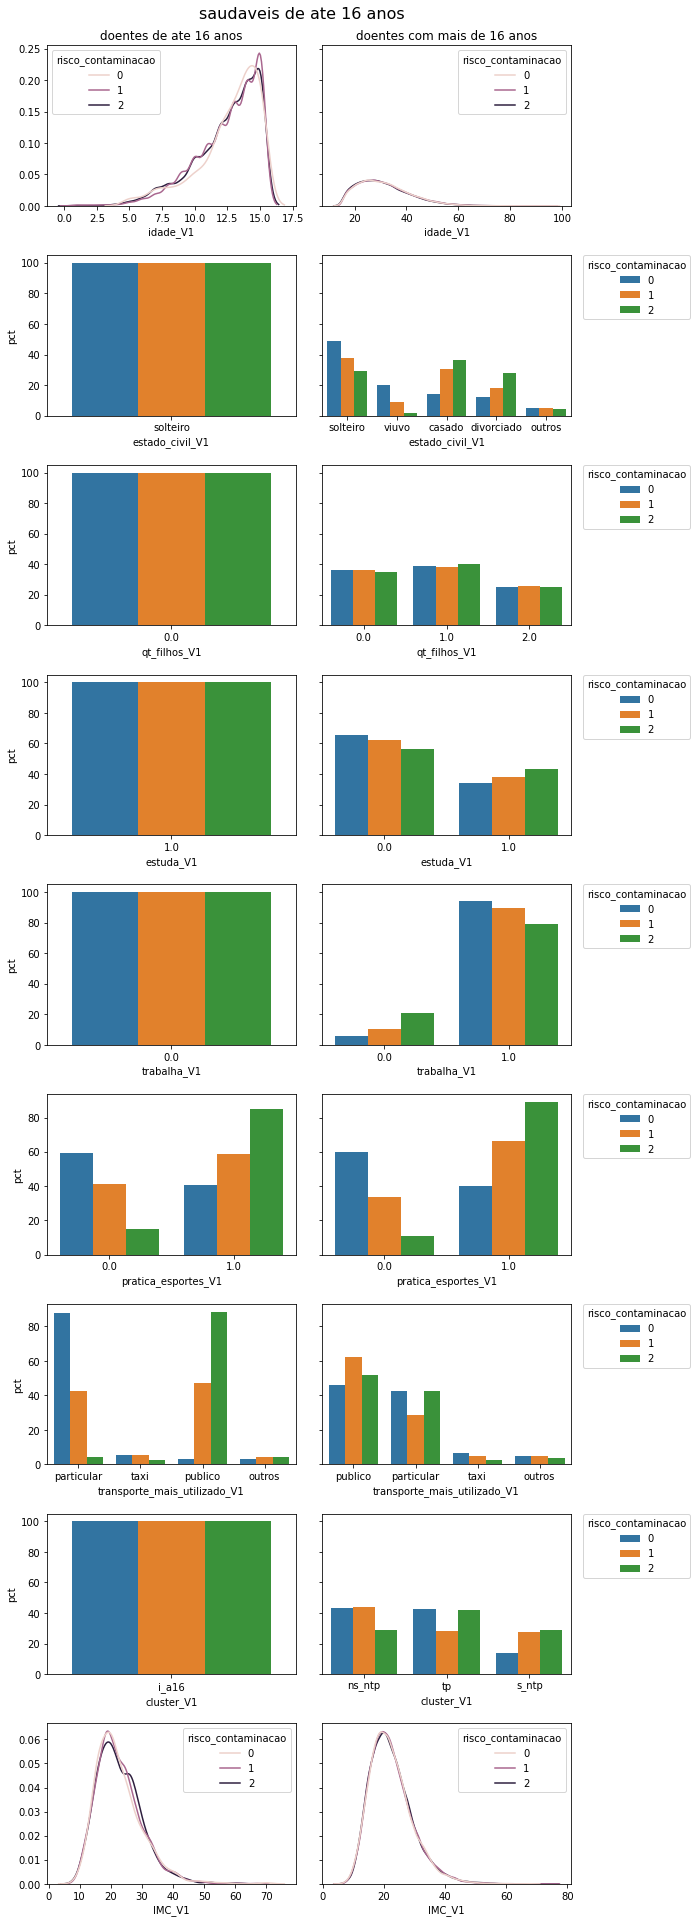

In [156]:
df_s_a16 = df.loc[~mask_2]

fig, ax = plt.subplots(9, 2, figsize=(8, 27), sharey='row')
fig.tight_layout(h_pad=3)
fig.subplots_adjust(top=0.96)
fig.suptitle('saudaveis de ate 16 anos', fontsize=16)

sns.kdeplot(x='idade_V1', hue='risco_contaminacao', data=df_s_a16.loc[~mask_1], common_norm=False, ax=ax[0, 0])
ax[0, 0].set_title('doentes de ate 16 anos')
ax[0, 0].set_ylabel('')
sns.kdeplot(x='idade_V1', hue='risco_contaminacao', data=df_s_a16.loc[mask_1], common_norm=False, ax=ax[0, 1])
ax[0, 1].set_title('doentes com mais de 16 anos')
ax[0, 1].set_ylabel('')

for n, c in enumerate(cols_1, start=1):
    tmp_1 = (df_s_a16
             .loc[~mask_1]
             .groupby('risco_contaminacao')[c]
             .value_counts(normalize=True)
             .mul(100)
             .rename('pct')
             .reset_index())
    sns.barplot(x=c, y='pct', data=tmp_1, hue='risco_contaminacao', ax=ax[n, 0])
    handles, labels = ax[n, 0].get_legend_handles_labels()
    ax[n, 0].legend(handles[:3],
                    labels[:3],
                    bbox_to_anchor=(1.05, 1),
                    loc=2,
                    borderaxespad=0,
                    title='risco_contaminacao')
    ax[n, 0].get_legend().remove()
    
    tmp_2 = (df_s_a16
             .loc[mask_1]
             .groupby('risco_contaminacao')[c]
             .value_counts(normalize=True)
             .mul(100)
             .rename('pct')
             .reset_index())
    sns.barplot(x=c, y='pct', data=tmp_2, hue='risco_contaminacao', ax=ax[n, 1])
    handles, labels = ax[n, 1].get_legend_handles_labels()
    ax[n, 1].legend(handles[:3],
                    labels[:3],
                    bbox_to_anchor=(1.05, 1),
                    loc=2,
                    borderaxespad=0,
                    title='risco_contaminacao')
    ax[n, 1].set_ylabel('')
        
sns.kdeplot(x='IMC_V1', hue='risco_contaminacao', data=df_s_a16.loc[~mask_1], common_norm=False, ax=ax[8, 0])
ax[8, 0].set_ylabel('')
sns.kdeplot(x='IMC_V1', hue='risco_contaminacao', data=df_s_a16.loc[mask_1], common_norm=False, ax=ax[8, 1])
ax[8, 1].set_ylabel('')

# plt.savefig('../data/images/comp_grupos_risco_titulo_1.png', bbox_inches='tight');

Em relações envolvendo doentes, e saudáveis de até 16 anos:

* Intra-grupo, a proporção daqueles que praticam esportes permanece praticamente a mesma, independente do nível de risco do grupo e da idade do doente. No entanto, entre grupos, a proporção dos praticantes é maior quanto maior o risco do grupo a que pertencem.

* Ente os doentes com até 16 anos, os usuários de tranporte público são amplamente dominantes no grupo de alto risco, enquanto no grupo de baixo risco o domínio é igualmente amplo por parte dos usuários de transporte particular. No grupo de médio risco, o domínio é praticamente equivalente entre usuários destes mesmos tipos de transporte. Já entre os doentes com mais de 16 anos, o domínio ainda é dos usuários de transportes público e particular, no entanto as proporções variam intra-grupo a depender do risco.

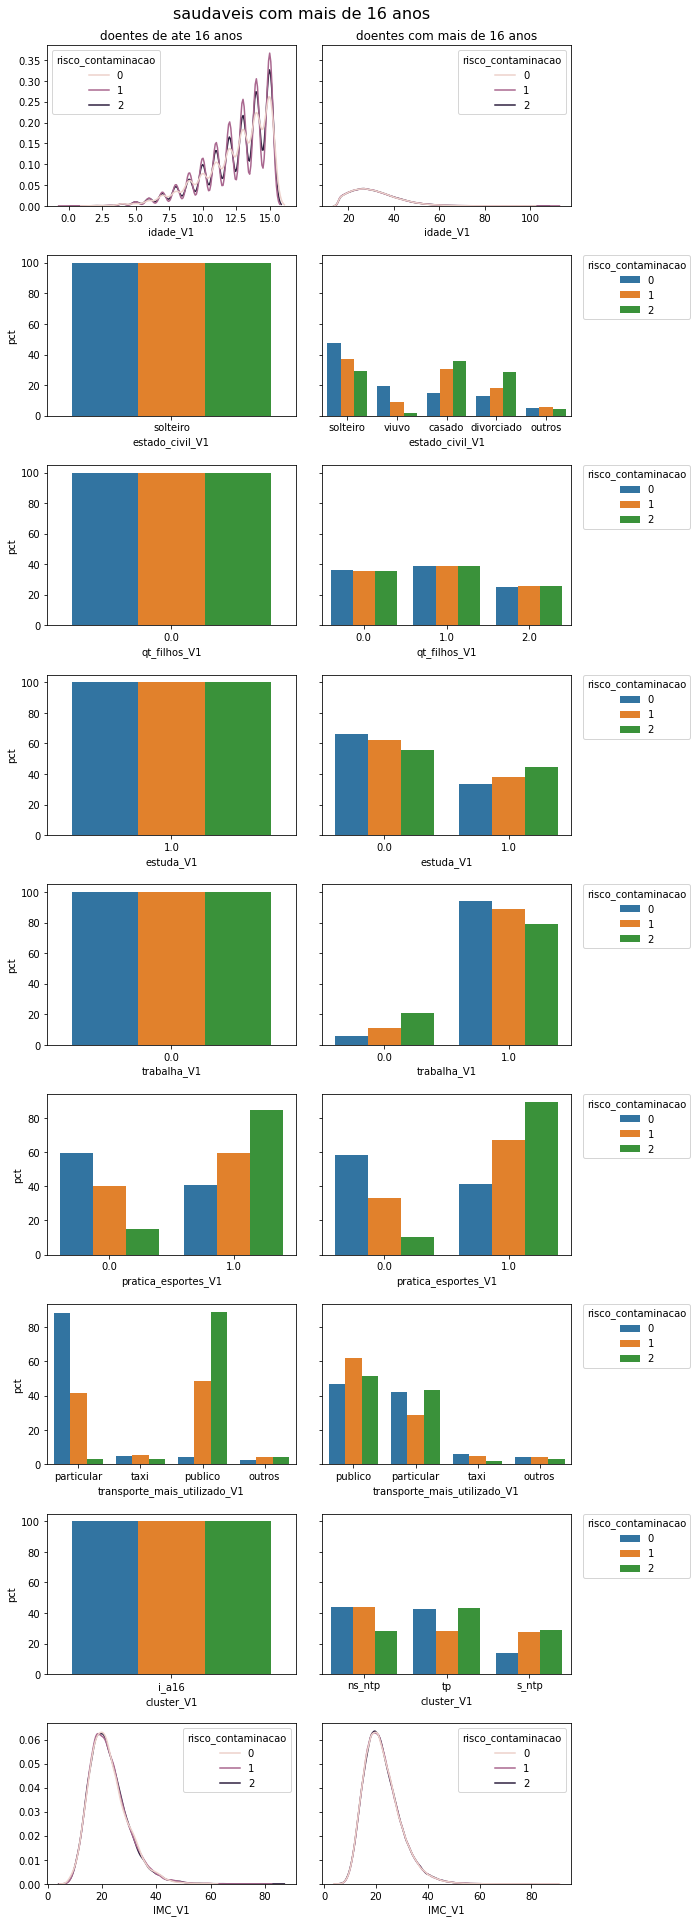

In [157]:
df_s_16m = df.loc[mask_2]

fig, ax = plt.subplots(9, 2, figsize=(8, 27), sharey='row')
fig.tight_layout(h_pad=3)
fig.subplots_adjust(top=0.96)
fig.suptitle('saudaveis com mais de 16 anos', fontsize=16)

sns.kdeplot(x='idade_V1', hue='risco_contaminacao', data=df_s_16m.loc[~mask_1], common_norm=False, ax=ax[0, 0])
ax[0, 0].set_title('doentes de ate 16 anos')
ax[0, 0].set_ylabel('')
sns.kdeplot(x='idade_V1', hue='risco_contaminacao', data=df_s_16m.loc[mask_1], common_norm=False, ax=ax[0, 1])
ax[0, 1].set_title('doentes com mais de 16 anos')
ax[0, 1].set_ylabel('')

for n, c in enumerate(cols_1, start=1):
    tmp_1 = (df_s_16m
             .loc[~mask_1]
             .groupby('risco_contaminacao')[c]
             .value_counts(normalize=True)
             .mul(100)
             .rename('pct')
             .reset_index())
    sns.barplot(x=c, y='pct', data=tmp_1, hue='risco_contaminacao', ax=ax[n, 0])
    handles, labels = ax[n, 0].get_legend_handles_labels()
    ax[n, 0].get_legend().remove()
    
    tmp_2 = (df_s_16m
             .loc[mask_1]
             .groupby('risco_contaminacao')[c]
             .value_counts(normalize=True)
             .mul(100)
             .rename('pct')
             .reset_index())
    sns.barplot(x=c, y='pct', data=tmp_2, hue='risco_contaminacao', ax=ax[n, 1])
    handles, labels = ax[n, 1].get_legend_handles_labels()
    ax[n, 1].legend(handles[:3],
                       labels[:3],
                       bbox_to_anchor=(1.05, 1),
                       loc=2,
                       borderaxespad=0,
                       title='risco_contaminacao')
    ax[n, 1].set_ylabel('')
        
sns.kdeplot(x='IMC_V1', hue='risco_contaminacao', data=df_s_16m.loc[~mask_1], common_norm=False, ax=ax[8, 0])
ax[8, 0].set_ylabel('')
sns.kdeplot(x='IMC_V1', hue='risco_contaminacao', data=df_s_16m.loc[mask_1], common_norm=False, ax=ax[8, 1])
ax[8, 1].set_ylabel('');

Em relações envolvendo doentes, e saudáveis com mais de 16 anos, os perfis dos doentes, independente de idade e de grupo de risco, são praticaente iguais àqueles em relações envolvendo doentes, e saudáveis com mais de 16 anos. Esse fato indica ausência de correlação entre a idade dos indivíduos saudáveis e os perfis daqueles doentes.

Text(311.49090909090904, 0.5, '')

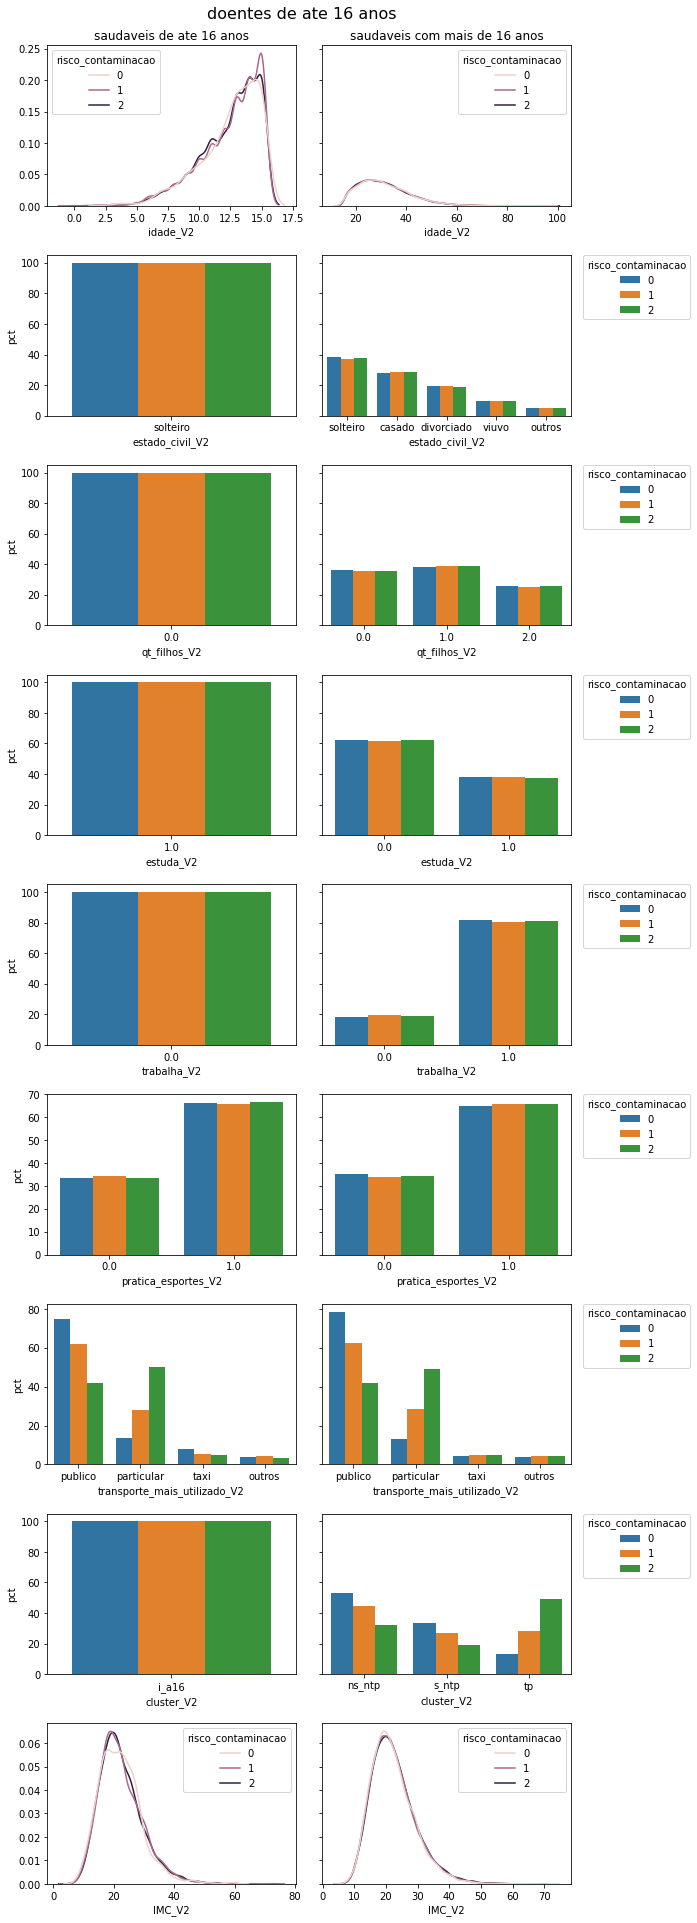

In [158]:
df_d_a16 = df.loc[~mask_1]

fig, ax = plt.subplots(9, 2, figsize=(8, 27), sharey='row')
fig.tight_layout(h_pad=3)
fig.subplots_adjust(top=0.96)
fig.suptitle('doentes de ate 16 anos', fontsize=16)

sns.kdeplot(x='idade_V2', hue='risco_contaminacao', data=df_d_a16.loc[~mask_2], common_norm=False, ax=ax[0, 0])
ax[0, 0].set_title('saudaveis de ate 16 anos')
ax[0, 0].set_ylabel('')
sns.kdeplot(x='idade_V2', hue='risco_contaminacao', data=df_d_a16.loc[mask_2], common_norm=False, ax=ax[0, 1])
ax[0, 1].set_title('saudaveis com mais de 16 anos')
ax[0, 1].set_ylabel('')

for n, c in enumerate(cols_2, start=1):
    tmp_1 = (df_d_a16
             .loc[~mask_2]
             .groupby('risco_contaminacao')[c]
             .value_counts(normalize=True)
             .mul(100)
             .rename('pct')
             .reset_index())
    sns.barplot(x=c, y='pct', data=tmp_1, hue='risco_contaminacao', ax=ax[n, 0])
    handles, labels = ax[n, 0].get_legend_handles_labels()
    ax[n, 0].get_legend().remove()
    
    tmp_2 = (df_d_a16
             .loc[mask_2]
             .groupby('risco_contaminacao')[c]
             .value_counts(normalize=True)
             .mul(100)
             .rename('pct')
             .reset_index())
    sns.barplot(x=c, y='pct', data=tmp_2, hue='risco_contaminacao', ax=ax[n, 1])
    handles, labels = ax[n, 1].get_legend_handles_labels()
    ax[n, 1].legend(handles[:3],
                    labels[:3],
                    bbox_to_anchor=(1.05, 1),
                    loc=2,
                    borderaxespad=0,
                    title='risco_contaminacao')
    ax[n, 1].set_ylabel('')
        
sns.kdeplot(x='IMC_V2', hue='risco_contaminacao', data=df_d_a16.loc[~mask_2], common_norm=False, ax=ax[8, 0])
ax[8, 0].set_ylabel('')
sns.kdeplot(x='IMC_V2', hue='risco_contaminacao', data=df_d_a16.loc[mask_2], common_norm=False, ax=ax[8, 1])
ax[8, 1].set_ylabel('')

# plt.savefig('../data/images/comp_grupos_risco_2.png', bbox_inches='tight');

Em relações envolvendo saudáveis, e doentes de até 16 anos:

* Indivíduos saudáveis tendem a praticar esportes praticamente na mesma proporção, independente de idade e de grupo de risco a que pertencem.

* O mesmo fenômeno acima é observado com transportes mais utilizados, com uma notável preferência para os do tipo público e particular. Em especial, a proporção dos saudáveis que utilizam transporte público é amplamente superior à dos que utilizam transporte particular no grupo de baixo risco.

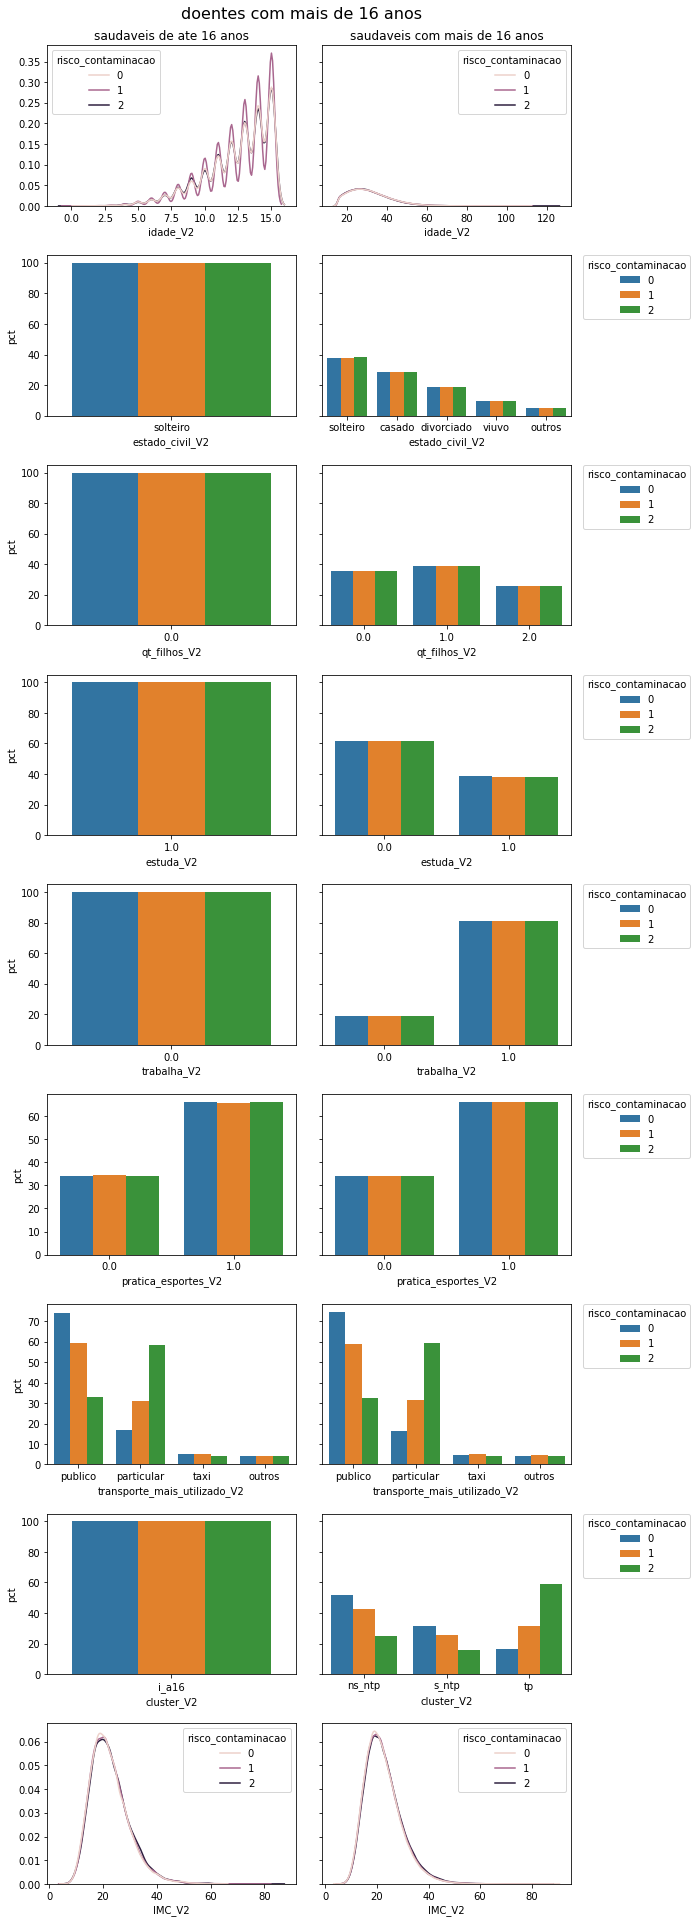

In [159]:
df_d_16m = df.loc[mask_1]

fig, ax = plt.subplots(9, 2, figsize=(8, 27), sharey='row')
fig.tight_layout(h_pad=3)
fig.subplots_adjust(top=0.96)
fig.suptitle('doentes com mais de 16 anos', fontsize=16)

sns.kdeplot(x='idade_V2', hue='risco_contaminacao', data=df_d_16m.loc[~mask_2], common_norm=False, ax=ax[0, 0])
ax[0, 0].set_title('saudaveis de ate 16 anos')
ax[0, 0].set_ylabel('')
sns.kdeplot(x='idade_V2', hue='risco_contaminacao', data=df_d_16m.loc[mask_2], common_norm=False, ax=ax[0, 1])
ax[0, 1].set_title('saudaveis com mais de 16 anos')
ax[0, 1].set_ylabel('')

for n, c in enumerate(cols_2, start=1):
    tmp_1 = (df_d_16m
             .loc[~mask_2]
             .groupby('risco_contaminacao')[c]
             .value_counts(normalize=True)
             .mul(100)
             .rename('pct')
             .reset_index())
    sns.barplot(x=c, y='pct', data=tmp_1, hue='risco_contaminacao', ax=ax[n, 0])
    handles, labels = ax[n, 0].get_legend_handles_labels()
    ax[n, 0].get_legend().remove()
    
    tmp_2 = (df_d_16m
             .loc[mask_2]
             .groupby('risco_contaminacao')[c]
             .value_counts(normalize=True)
             .mul(100)
             .rename('pct')
             .reset_index())
    sns.barplot(x=c, y='pct', data=tmp_2, hue='risco_contaminacao', ax=ax[n, 1])
    handles, labels = ax[n, 1].get_legend_handles_labels()
    ax[n, 1].legend(handles[:3],
                    labels[:3],
                    bbox_to_anchor=(1.05, 1),
                    loc=2,
                    borderaxespad=0,
                    title='risco_contaminacao')
    ax[n, 1].set_ylabel('')
        
sns.kdeplot(x='IMC_V2', hue='risco_contaminacao', data=df_d_16m.loc[~mask_2], common_norm=False, ax=ax[8, 0])
ax[8, 0].set_ylabel('')
sns.kdeplot(x='IMC_V2', hue='risco_contaminacao', data=df_d_16m.loc[mask_2], common_norm=False, ax=ax[8, 1])
ax[8, 1].set_ylabel('');

Novamente, desta vez em relações envolvendo saudáveis, e doentes de até 16 anos, os perfis dos saudáveis, independente de idade e de grupo de risco, são praticaente iguais àqueles em relações envolvendo saudáveis, e doentes com mais de 16 anos. Esse fato indica ausência de correlação entre a idade dos indivíduos doentes e os perfis daqueles saudáveis.

Text(311.49090909090904, 0.5, '')

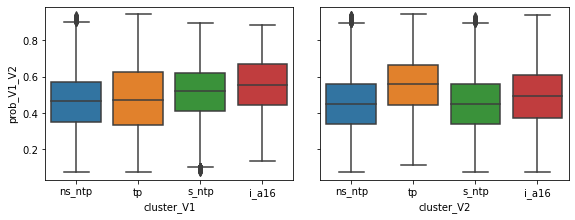

In [160]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
fig.tight_layout()

sns.boxplot(x='cluster_V1', y='prob_V1_V2', data=df, ax=ax[0])
sns.boxplot(x='cluster_V2', y='prob_V1_V2', data=df, ax=ax[1])
ax[1].set_ylabel('')

# plt.savefig('../data/images/boxplot_1.png', bbox_inches='tight');

In [161]:
display(df.groupby('cluster_V1')['prob_V1_V2'].describe().T)
display(df.groupby('cluster_V2')['prob_V1_V2'].describe().T)

cluster_V1,i_a16,ns_ntp,s_ntp,tp
count,145246.000000,765968.000000,468264.000000,620520.000000
mean,0.548277,0.460966,0.512856,0.478773
std,0.154096,0.146051,0.138830,0.181720
min,0.135785,0.076258,0.076545,0.074462
25%,0.441574,0.350019,0.412106,0.334898
50%,0.553785,0.464962,0.521638,0.472140
75%,0.671927,0.569868,0.617874,0.623138
max,0.886379,0.939301,0.892750,0.942245


cluster_V2,i_a16,ns_ntp,s_ntp,tp
count,144536.000000,767624.000000,468108.000000,619730.000000
mean,0.490492,0.450997,0.450821,0.551591
std,0.160003,0.151769,0.152067,0.152021
min,0.075103,0.074462,0.075117,0.112480
25%,0.370276,0.338517,0.338172,0.444823
50%,0.493972,0.450826,0.450790,0.562227
75%,0.611627,0.561891,0.561502,0.666653
max,0.940965,0.942019,0.934711,0.942245


Desconsiderando as relações existentes entre indivíduos doentes e saudáveis:

* Em doentes, a taxa média de contaminação tende a ser maior no grupo dos que têm menos de 16 anos, e menor no grupo dos que não são solteiros e que usam pouco transporte particular.

* Em saudáveis, a taxa média de contaminação tende a ser maior no grupo dos que utilizam mais transporte particular, e menor nos grupos dos que usam pouco transporte particular.

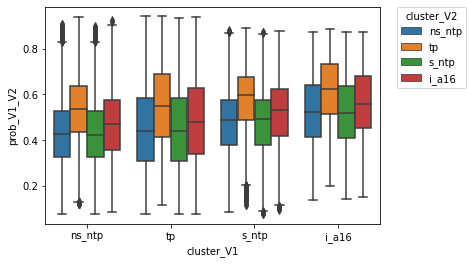

In [162]:
g = sns.boxplot(x='cluster_V1', y='prob_V1_V2', hue='cluster_V2', data=df)
g.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, title='cluster_V2')

# plt.savefig('../data/images/boxplot_2.png', bbox_inches='tight');

In [163]:
df.groupby(['cluster_V1', 'cluster_V2'])['prob_V1_V2'].describe()

count      mean       std       min       25%  \
cluster_V1 cluster_V2                                                     
i_a16      i_a16        10518.0  0.556357  0.155199  0.149479  0.452652   
           ns_ntp       55976.0  0.515695  0.148029  0.135785  0.415134   
           s_ntp        33626.0  0.513368  0.148632  0.140546  0.408481   
           tp           45126.0  0.612821  0.144112  0.199117  0.514800   
ns_ntp     i_a16        55322.0  0.466299  0.147352  0.082403  0.354715   
           ns_ntp      293126.0  0.426274  0.136668  0.076258  0.327041   
           s_ntp       180074.0  0.426116  0.136714  0.076696  0.326889   
           tp          237446.0  0.528980  0.139571  0.117618  0.433897   
s_ntp      i_a16        33990.0  0.519001  0.138472  0.092756  0.419151   
           ns_ntp      179770.0  0.477315  0.130823  0.082018  0.377411   
           s_ntp       108962.0  0.478553  0.130748  0.076545  0.379930   
           tp          145542.0  0.581003  0.128456  0.115513  0.487278   
tp         i_a16        44706.0  0.483259  0.182322  0.075103  0.339377   
           ns_ntp      238752.0  0.446367  0.175575  0.074462  0.309243   
           s_ntp       145446.0  0.446173  0.176385  0.075117  0.309163   
           tp          191616.0  0.542850  0.175873  0.112480  0.412434   

                            50%       75%       max  
cluster_V1 cluster_V2                                
i_a16      i_a16       0.559065  0.680804  0.875295  
           ns_ntp      0.521415  0.639235  0.874373  
           s_ntp       0.520042  0.637037  0.872241  
           tp          0.625542  0.731666  0.886379  
ns_ntp     i_a16       0.470700  0.576205  0.927888  
           ns_ntp      0.424108  0.528793  0.907672  
           s_ntp       0.423841  0.528309  0.899212  
           tp          0.535555  0.638549  0.939301  
s_ntp      i_a16       0.529777  0.623185  0.880271  
           ns_ntp      0.489155  0.574901  0.880887  
           s_ntp       0.491876  0.575357  0.872072  
           tp          0.598348  0.677600  0.892750  
tp         i_a16       0.478028  0.628701  0.940965  
           ns_ntp      0.438487  0.585636  0.942019  
           s_ntp       0.438146  0.586024  0.934711  
           tp          0.549188  0.689432  0.942245

Agora, considerando as relações existentes entre indivíduos doentes e saudáveis:

* A taxa média de contaminação é a maior entre doentes com menos de 16 anos e saudáveis que utilizam mais tranporte particular.

* A taxa média de contaminação é a menor entre doentes não-solteiros e que utilizam pouco transporte particular, e saudáveis que utilizam pouco tranporte particular.